<a href="https://www.kaggle.com/code/mymaitr/thesis-nn-bnn-glm?scriptVersionId=185509650" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### In this notebook
Thank aldparis so much for a clear notebook. Here is his markdown.

"There are several kind of features in this challenge : text, categorical, continous. Before each regression, we need to fit different transformers for every kind of features. There is an inflation problem with continous features and there are some extrem values => log transformation and standardize transformation by year of accident are usefull forseveral regression methods (ridge, NN). 

A score on **ClaimDescription** text will be used as a feature in those regressors.
And there is a faster implementation of LDA than in https://www.kaggle.com/tanguypledel/topic-modeling-implementation. "

### What I added
I use Bayesian neural network to measure the epistemic uncertainty in the model. (You can read more about the methods in my pdf file on Github: tmym0330/Bayesian-neural-network-measure-uncertainty-for-actuarial-prediction.) 

Besides, a GLM (a traditional statistical model) is added to compare with 2 DL models.

I also choose 10 data points to visualize with the aim of proving the benefit of BNN in predict an interval for each point of test set.

In [288]:
import gc
gc.collect()

41

## Constants & libraries

In [289]:
__seed = 222
__n_folds = 5

__data_path ="../input/actuarial-loss-estimation"

import numpy as np 

import pandas as pd 
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 200)

import matplotlib.pyplot as plt
import seaborn as sns

import random

# To be able to create my own scikit transformer
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared = False)

from sklearn.model_selection import StratifiedKFold, train_test_split
folds = StratifiedKFold(n_splits=__n_folds, random_state = __seed, shuffle = True)

In [290]:
print(folds)

StratifiedKFold(n_splits=5, random_state=222, shuffle=True)


# Part 1 : train set and test set
## Read data

In [291]:
or_train_set = pd.read_csv(f"{__data_path}/train.csv", index_col = "ClaimNumber")
test_set = or_train_set.head(10800)
train_set = or_train_set[~or_train_set.index.isin(test_set.index)]

In [292]:


print("N rows in train set : {:,.0f} ".format(or_train_set.shape[0]))
print(f"N columns in train set : {or_train_set.shape[1]}")

print("\nColumns in train set are : {}".format(or_train_set.columns))

print("\nDtypes of each columns : \n{}".format(or_train_set.info()))

or_train_set.head()

N rows in train set : 54,000 
N columns in train set : 14

Columns in train set are : Index(['DateTimeOfAccident', 'DateReported', 'Age', 'Gender', 'MaritalStatus',
       'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'PartTimeFullTime', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'ClaimDescription', 'InitialIncurredCalimsCost',
       'UltimateIncurredClaimCost'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 54000 entries, WC8285054 to WC2542601
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTimeOfAccident         54000 non-null  object 
 1   DateReported               54000 non-null  object 
 2   Age                        54000 non-null  int64  
 3   Gender                     54000 non-null  object 
 4   MaritalStatus              53971 non-null  object 
 5   DependentChildren          54000 non-null  int64  
 6   DependentsOther    

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
ClaimNumber,,,,,,,,,,,,,,
WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388
WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819
WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087
WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170
WC2634037,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925


In [293]:
or_train_set.corr()

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredCalimsCost,UltimateIncurredClaimCost
Age,1.000000,0.064209,0.037479,0.176466,0.017311,0.031966,0.114900,0.102716
DependentChildren,0.064209,1.000000,0.197231,0.100867,0.035952,0.012861,0.044040,0.033450
DependentsOther,0.037479,0.197231,1.000000,0.057769,0.009795,0.004481,0.045477,0.027560
WeeklyWages,0.176466,0.100867,0.057769,1.000000,0.175591,0.206141,0.181325,0.151695
HoursWorkedPerWeek,0.017311,0.035952,0.009795,0.175591,1.000000,0.399353,0.007947,0.004543
DaysWorkedPerWeek,0.031966,0.012861,0.004481,0.206141,0.399353,1.000000,0.007460,0.001901
InitialIncurredCalimsCost,0.114900,0.044040,0.045477,0.181325,0.007947,0.007460,1.000000,0.394991
UltimateIncurredClaimCost,0.102716,0.033450,0.027560,0.151695,0.004543,0.001901,0.394991,1.000000


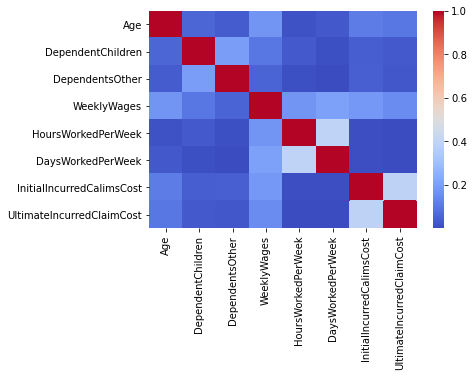

In [294]:
ax = plt.subplot()
sns.heatmap(or_train_set.corr(), cmap="coolwarm")


## Create sample with 10 points, including 5 outliers và 5 "normal points"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x79369f5ec1d0>,
      dtype=object)

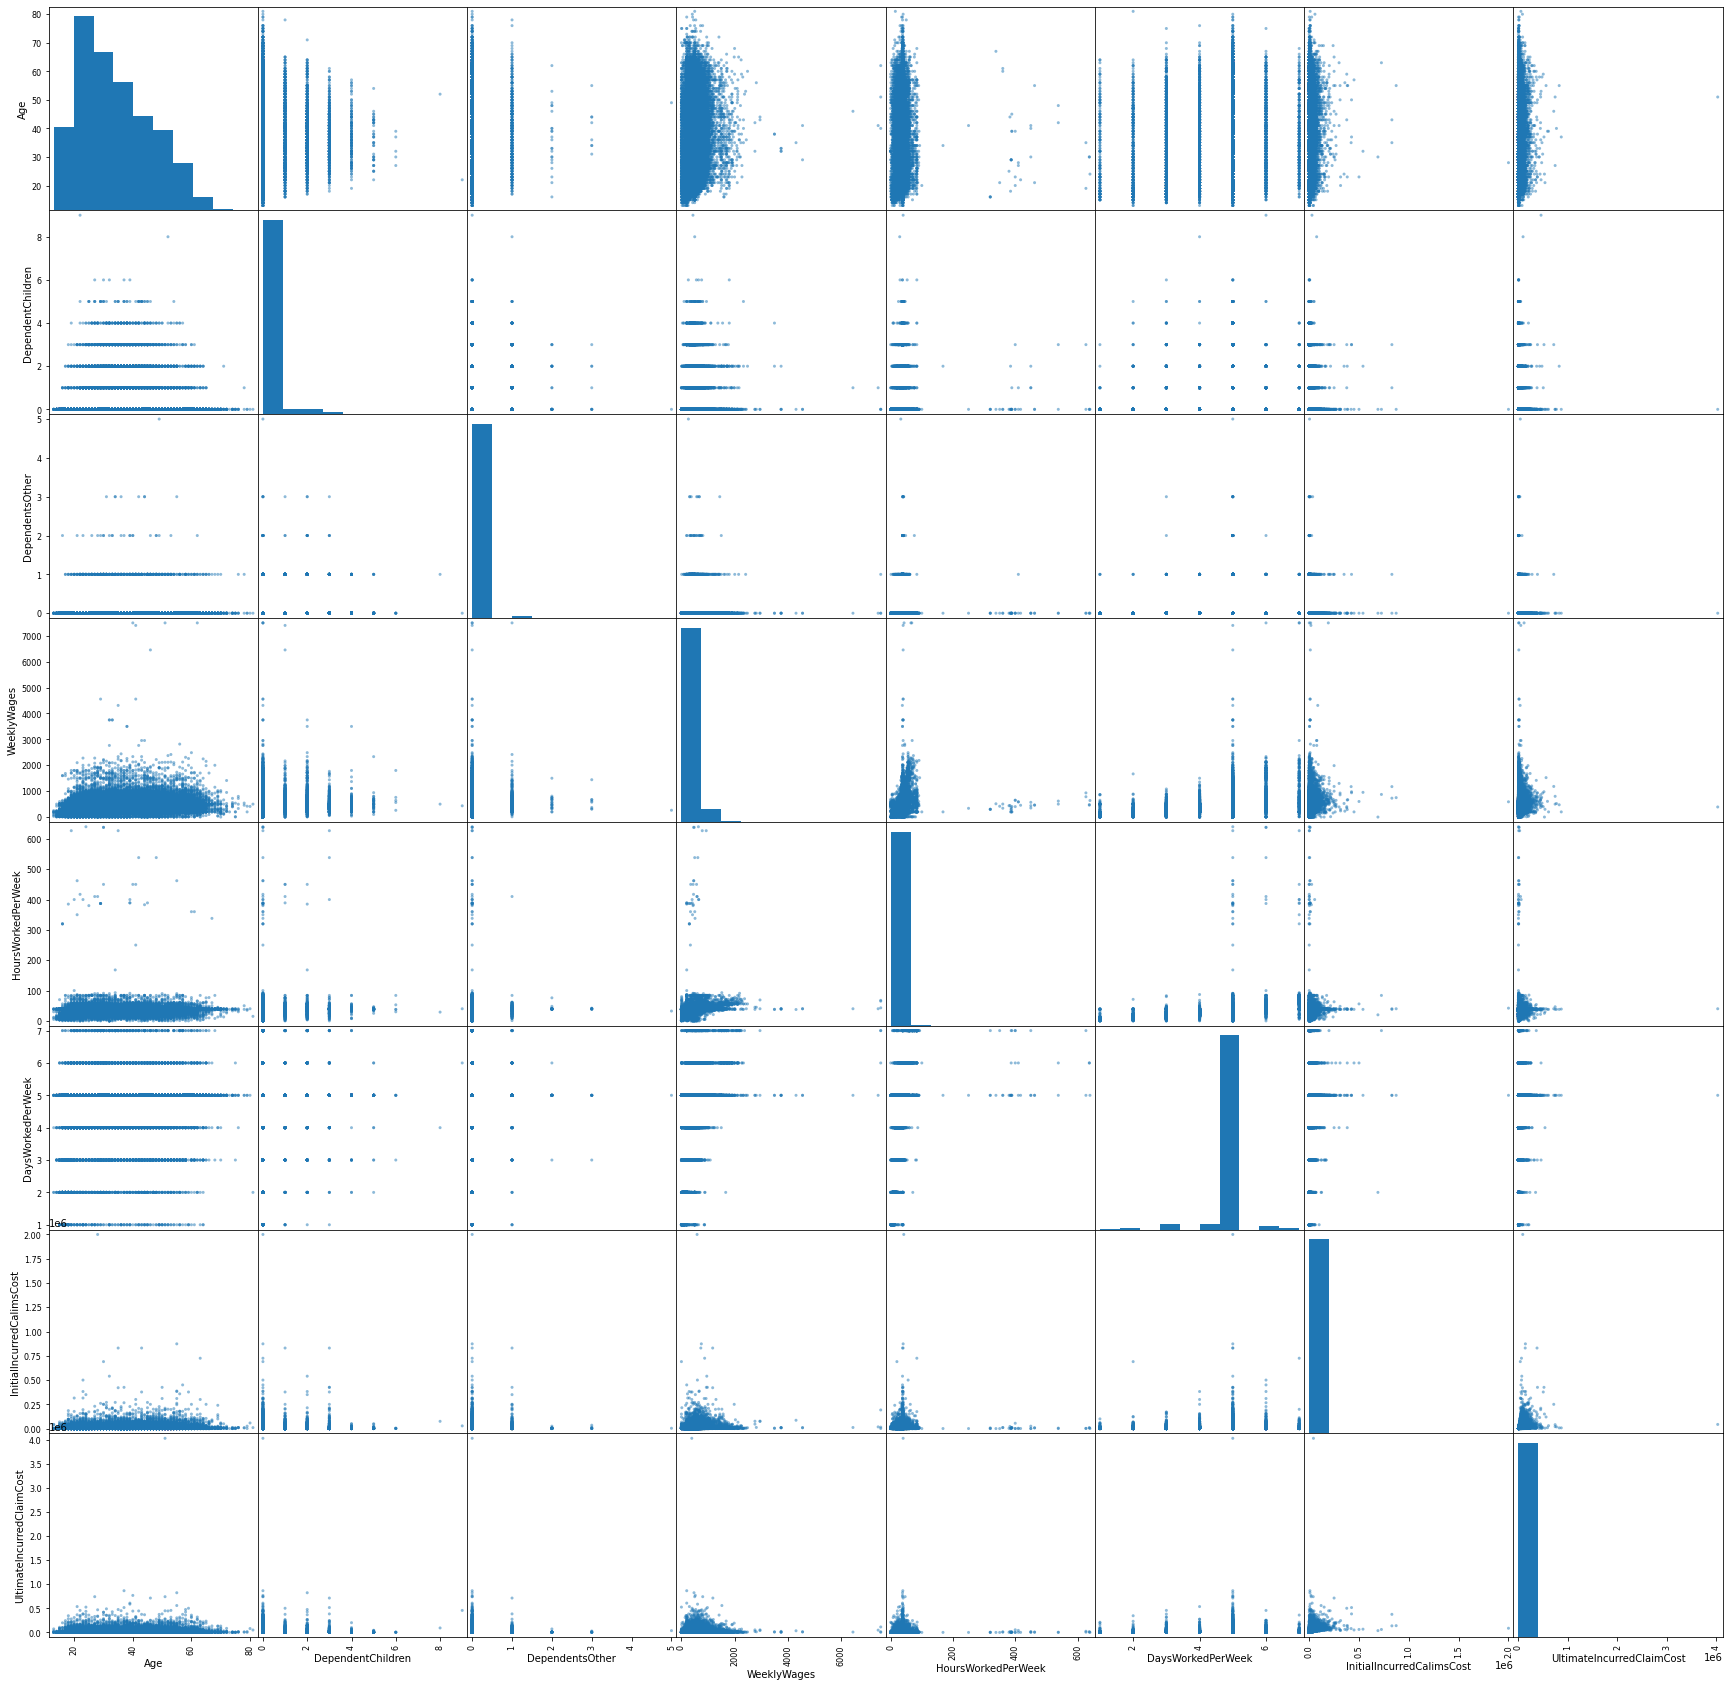

In [295]:
pd.plotting.scatter_matrix(or_train_set, alpha=0.5, figsize=(30,30))

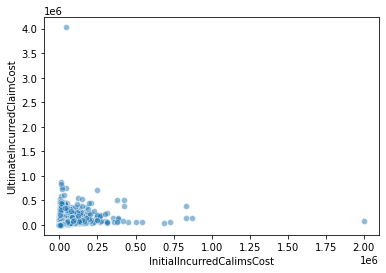

In [296]:
import seaborn as sns
sns.scatterplot(data = or_train_set, x='InitialIncurredCalimsCost', y='UltimateIncurredClaimCost', alpha=0.5)

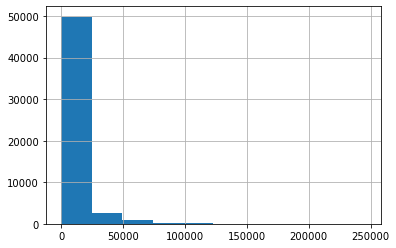

In [297]:
cond = or_train_set['InitialIncurredCalimsCost'] < 0.25e6
or_train_set[cond]['InitialIncurredCalimsCost'].hist() 

In [298]:
or_train_set.describe()

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredCalimsCost,UltimateIncurredClaimCost
count,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,5.400000e+04,5.400000e+04
mean,33.842370,0.119185,0.009944,416.364807,37.735084,4.905759,7.841146e+03,1.100337e+04
std,12.122165,0.517780,0.109348,248.638669,12.568704,0.552129,2.058408e+04,3.339099e+04
min,13.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,1.218868e+02
25%,23.000000,0.000000,0.000000,200.000000,38.000000,5.000000,7.000000e+02,9.263384e+02
50%,32.000000,0.000000,0.000000,392.200000,38.000000,5.000000,2.000000e+03,3.371242e+03
75%,43.000000,0.000000,0.000000,500.000000,40.000000,5.000000,9.500000e+03,8.197249e+03
max,81.000000,9.000000,5.000000,7497.000000,640.000000,7.000000,2.000000e+06,4.027136e+06



### Find outliers

In [299]:
cond = (test_set['InitialIncurredCalimsCost'] > 0.25e5) & (test_set['InitialIncurredCalimsCost'] <0.35e5)
test_set[cond].shape

(170, 14)

In [300]:
cond = test_set['UltimateIncurredClaimCost'] > 0.5e5
test_set[cond]

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
ClaimNumber,,,,,,,,,,,,,,
WC8342953,2002-01-30T09:00:00Z,2002-02-07T00:00:00Z,58,M,M,0,0,525.00,F,40.0,5,FALL FROM A LADDER STRAIN RIGHT SHOULDER,25000,105285.14860
WC2633986,1990-01-21T11:00:00Z,1990-03-13T00:00:00Z,42,M,S,0,0,276.60,P,12.5,2,TRANSFERRING PATIENT SHOULDER STRAIN,67000,53122.90481
WC9004661,2003-03-12T13:00:00Z,2003-04-10T00:00:00Z,32,M,M,3,0,480.50,F,38.0,5,FELL OFF LADDER FRACTURE RIGHT WRIST,111077,111405.82140
WC9446411,2004-09-30T11:00:00Z,2004-10-23T00:00:00Z,44,M,M,1,0,612.00,F,40.0,5,NORMAL WORK DUTIES TENNIS ELBOW RIGHT ELBOW,136612,173722.39480
WC7639313,2000-11-13T09:00:00Z,2000-11-28T00:00:00Z,24,M,U,0,0,1246.15,F,40.0,5,CRUSHED STEEL DOOR BRUISED BACK,100000,59868.41404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC4436862,1994-05-26T14:00:00Z,1994-07-23T00:00:00Z,37,M,U,0,0,930.00,F,40.0,5,LIFTING TOP PLATE BACK STRAIN,24000,88891.84959
WC9533635,2004-08-04T10:00:00Z,2004-08-15T00:00:00Z,31,F,U,0,0,587.00,F,40.0,5,MOVING SHELVES STRAIN SHOULDERS,124000,104140.69110
WC8529792,2002-10-22T13:00:00Z,2002-10-31T00:00:00Z,58,M,S,0,0,600.00,F,38.0,5,FELL FROM LADDER THORACIC SPINE,50000,78961.62219


In [301]:
test_set[test_set['WeeklyWages'] > 2000.000000]

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
ClaimNumber,,,,,,,,,,,,,,
WC9859519,2005-11-09T07:00:00Z,2005-11-17T00:00:00Z,54,M,S,0,0,2100.00,F,56.0,6,HIT NECK BOX STRAIN LOWER BACK,20000,16151.583330
WC2608771,1990-11-26T12:00:00Z,1991-01-02T00:00:00Z,33,F,S,0,0,3750.00,F,38.0,5,WHILE FITTING LIGHT FITTING LOWER BACK,11000,22314.593240
WC2929873,1990-02-08T22:00:00Z,1990-03-05T00:00:00Z,32,M,S,2,0,3750.00,F,40.0,5,GETTING IN CAR DOOR AND FRAME CRUSH INJURY RIG...,8100,4397.924710
WC8354255,2002-07-11T14:00:00Z,2002-07-14T00:00:00Z,29,M,U,0,0,2080.28,F,65.0,7,FALLING TABLES LEFT FOOT FRACTURE LEFT FOOT,15000,13201.382820
WC5302778,1995-08-03T13:00:00Z,1995-08-29T00:00:00Z,39,F,S,0,0,2010.58,F,38.0,5,STRUCK WITH HAMMER STRAINED LOWER BACK STRAIN,12600,13132.530160
WC8479271,2002-05-27T01:00:00Z,2002-06-16T00:00:00Z,38,M,M,1,0,2168.56,F,75.0,7,SLIPPED STAIR SPRAIN RIGHT KNEE STRAIN THORACI...,3300,7753.374789
WC9596420,2005-12-13T08:00:00Z,2005-12-28T00:00:00Z,53,M,M,0,0,2125.00,F,56.0,6,PICKED UP BOX LOWER BACK SPRAIN,8600,10236.282450
WC9622051,2005-06-16T09:00:00Z,2005-06-22T00:00:00Z,31,M,M,2,0,2159.86,F,56.0,6,SLIPPED AND HIT KNEE RIGHT KNEE,5400,7543.631484
WC5915110,1997-10-01T10:00:00Z,1997-11-06T00:00:00Z,42,M,M,0,0,2766.04,F,38.0,5,STRUCK SLIPPED WITH KNIFE LACERATION RIGHT SHIN,46000,21109.381280


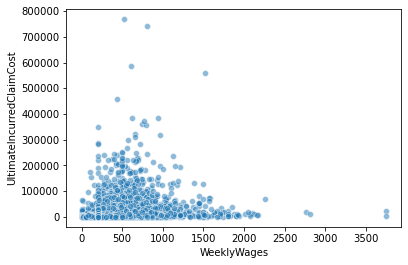

In [302]:
sns.scatterplot(data = test_set, x='WeeklyWages', y='UltimateIncurredClaimCost', alpha=0.5)

In [303]:
out_test = test_set.loc[['WC7792914', 'WC8104294', 'WC5915110', 'WC9879169', 'WC2633986']]

# WC9540190: very difficult to predict
# WC4436862   : small range bnn

In [304]:
out_test

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
ClaimNumber,,,,,,,,,,,,,,
WC7792914,2001-06-19T19:00:00Z,2001-07-10T00:00:00Z,24,M,U,2,1,524.50,F,38.0,5,STRUCK FALLING CONTAINER CONCUSSION HEAD,350000,144508.92940
WC8104294,2001-04-04T12:00:00Z,2001-05-17T00:00:00Z,57,M,S,0,0,200.00,F,38.0,6,WORKPLACE STRESS STRESS WORKPLACE,450000,51362.33999
WC5915110,1997-10-01T10:00:00Z,1997-11-06T00:00:00Z,42,M,M,0,0,2766.04,F,38.0,5,STRUCK SLIPPED WITH KNIFE LACERATION RIGHT SHIN,46000,21109.38128
WC9879169,2005-07-09T16:00:00Z,2006-06-10T00:00:00Z,55,F,S,0,0,1522.70,F,40.0,5,CAUGHT BETWEEN DOOR FRAME GRAZE HEAD,119686,558408.96160
WC2633986,1990-01-21T11:00:00Z,1990-03-13T00:00:00Z,42,M,S,0,0,276.60,P,12.5,2,TRANSFERRING PATIENT SHOULDER STRAIN,67000,53122.90481


### "Normal points" (near mean, median of dataset)

In [305]:
cond = (test_set['InitialIncurredCalimsCost'] >= 2000) & (test_set['InitialIncurredCalimsCost'] <= 2500)
test_set[cond]

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
ClaimNumber,,,,,,,,,,,,,,
WC1766625,1988-03-16T18:00:00Z,1988-03-31T00:00:00Z,58,M,M,0,0,350.00,F,40.0,5,CUTTING DOWN A SMALL STEP SPRAINED TWISTED RIG...,2000,1538.284078
WC2986786,1990-04-26T11:00:00Z,1990-06-05T00:00:00Z,47,M,M,0,0,673.10,F,43.9,3,STRIKING AGAINST FORKLIFT PRONGS BRUISED RIGHT...,2000,1701.953836
WC1977842,1988-02-04T15:00:00Z,1988-03-08T00:00:00Z,49,M,M,1,0,300.00,F,38.0,5,FELL BACK AND HIT GLASS BROKEN DAMAGED GLASSES,2000,4175.629096
WC1630835,1988-02-05T16:00:00Z,1988-02-22T00:00:00Z,34,M,M,0,0,388.60,F,38.0,5,INFECTED RIGHT INDEX FINGER LACERATION LEFT IN...,2000,13022.533860
WC2638160,1990-03-21T18:00:00Z,1990-04-12T00:00:00Z,49,F,M,0,0,410.00,F,40.0,5,LIFTING PATIENT PULLED MUSCLE IN BACK AND SHOU...,2000,13500.370690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC3591164,1992-12-24T10:00:00Z,1993-01-09T00:00:00Z,31,M,U,0,0,690.63,F,37.0,5,LIFTING STEEL STRAIN RIGHT SHOULDER,2000,5754.680748
WC1927109,1988-02-08T06:00:00Z,1988-02-21T00:00:00Z,33,F,M,0,1,346.15,F,40.0,5,HIT ON CHAIR TWISTED KNEE RIGHT,2000,6768.983033
WC6939880,1999-10-20T14:00:00Z,2000-02-12T00:00:00Z,19,F,S,0,0,266.00,F,38.0,5,WORKING ON MACHINE PLATFORM STRAINED LEFT SHOU...,2000,2103.677369


In [306]:
cond = (test_set['UltimateIncurredClaimCost'] > 17000) & (test_set['UltimateIncurredClaimCost'] < 18000)
test_set[cond].head()

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
ClaimNumber,,,,,,,,,,,,,,
WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.48717
WC7368681,2000-02-21T13:00:00Z,2000-03-06T00:00:00Z,30,M,M,3,0,297.16,F,38.0,5,CARRYING RACK LOWER BACK STRAIN LOWER BACK STRAIN,10000,17916.25999
WC7749657,2001-07-31T10:00:00Z,2001-08-11T00:00:00Z,46,M,S,0,0,927.40,F,40.0,5,MOVING BACK AND NECK MUSCLE SPASM IN LOWER BACK,22000,17283.16229
WC2413504,1989-10-12T12:00:00Z,1989-12-13T00:00:00Z,61,M,M,0,0,480.04,F,40.0,5,SLIPPED FALL HIT CRATE STRAIN LOWER BACK STRAIN,17100,17871.87611
WC9263049,2004-02-20T19:00:00Z,2004-03-26T00:00:00Z,27,M,S,0,0,1000.00,F,40.0,5,LIFTING ANGLE IRON STRAIN LEFT SHOULDER STRAIN,15000,17457.51602


In [307]:
in_test = or_train_set.loc[['WC2986786', 'WC1766625', 'WC8127373', 'WC5287454', 'WC9548030']]

In [308]:
sample = pd.concat([out_test, in_test])

In [309]:
sample

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
ClaimNumber,,,,,,,,,,,,,,
WC7792914,2001-06-19T19:00:00Z,2001-07-10T00:00:00Z,24,M,U,2,1,524.50,F,38.0,5,STRUCK FALLING CONTAINER CONCUSSION HEAD,350000,144508.929400
WC8104294,2001-04-04T12:00:00Z,2001-05-17T00:00:00Z,57,M,S,0,0,200.00,F,38.0,6,WORKPLACE STRESS STRESS WORKPLACE,450000,51362.339990
WC5915110,1997-10-01T10:00:00Z,1997-11-06T00:00:00Z,42,M,M,0,0,2766.04,F,38.0,5,STRUCK SLIPPED WITH KNIFE LACERATION RIGHT SHIN,46000,21109.381280
WC9879169,2005-07-09T16:00:00Z,2006-06-10T00:00:00Z,55,F,S,0,0,1522.70,F,40.0,5,CAUGHT BETWEEN DOOR FRAME GRAZE HEAD,119686,558408.961600
WC2633986,1990-01-21T11:00:00Z,1990-03-13T00:00:00Z,42,M,S,0,0,276.60,P,12.5,2,TRANSFERRING PATIENT SHOULDER STRAIN,67000,53122.904810
WC2986786,1990-04-26T11:00:00Z,1990-06-05T00:00:00Z,47,M,M,0,0,673.10,F,43.9,3,STRIKING AGAINST FORKLIFT PRONGS BRUISED RIGHT...,2000,1701.953836
WC1766625,1988-03-16T18:00:00Z,1988-03-31T00:00:00Z,58,M,M,0,0,350.00,F,40.0,5,CUTTING DOWN A SMALL STEP SPRAINED TWISTED RIG...,2000,1538.284078
WC8127373,2002-09-23T15:00:00Z,2002-10-20T00:00:00Z,42,M,M,0,0,802.92,F,40.0,5,LIFTING DOOR STRAINED BACK,9500,10854.463640
WC5287454,1995-05-30T11:00:00Z,1995-08-29T00:00:00Z,36,M,M,2,0,437.75,F,38.0,5,LIFTING VINES LOWER BACK STRAIN LOWER BACK STRAIN,12600,11322.772180


## About Ultimate Incurred Claim Cost (target) and Initial Claim Cost

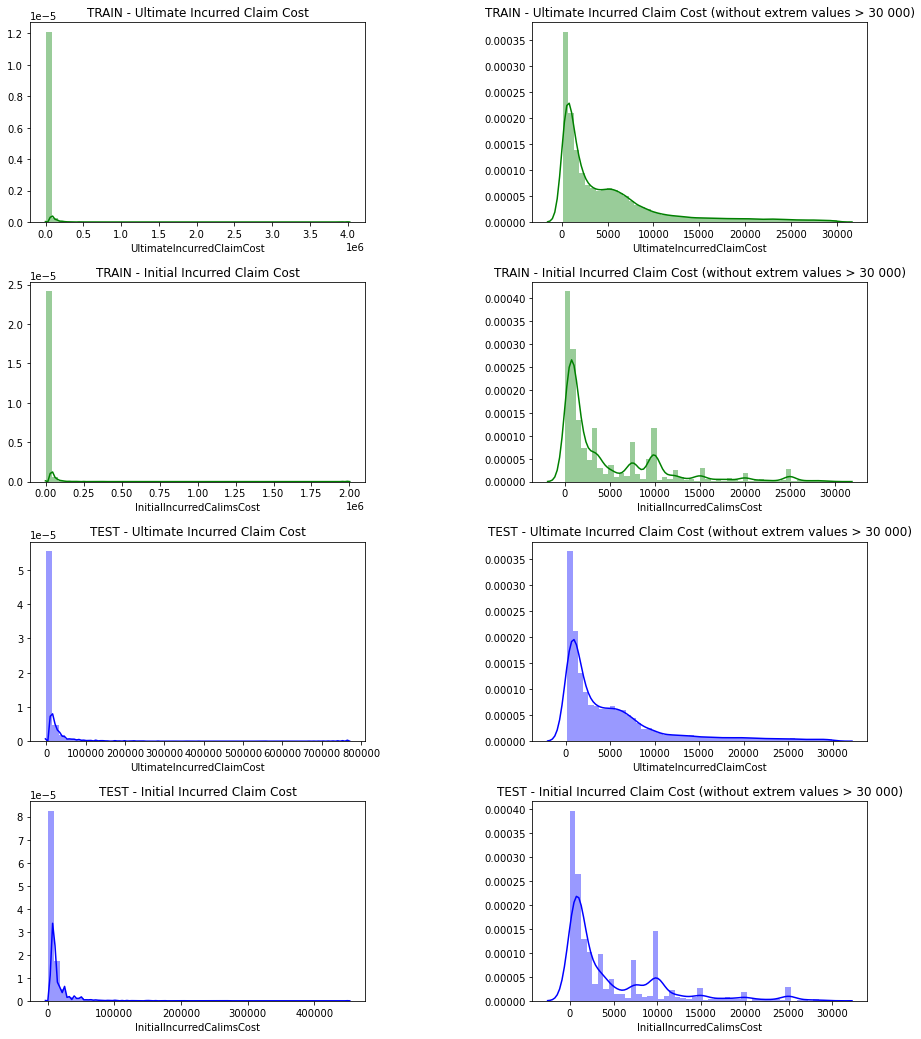

In [310]:
nrows, ncols = 4, 2
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(15, 4.5*nrows))

plt.subplots_adjust(hspace = 0.3, wspace = 0.5)
    
ax = plt.subplot(nrows, ncols, 1)
sns.distplot(train_set["UltimateIncurredClaimCost"], color="green", label="train", ax= ax)
ax.set_title("TRAIN - Ultimate Incurred Claim Cost");

ax = plt.subplot(nrows, ncols, 2)
sns.distplot(train_set.loc[train_set["UltimateIncurredClaimCost"]<30000, "UltimateIncurredClaimCost"], color="green", label="train", ax=ax)
ax.set_title("TRAIN - Ultimate Incurred Claim Cost (without extrem values > 30 000)");

ax = plt.subplot(nrows, ncols, 3)
sns.distplot(train_set["InitialIncurredCalimsCost"], color="green", label="train", ax= ax)

ax.set_title("TRAIN - Initial Incurred Claim Cost");

ax = plt.subplot(nrows, ncols, 4)
sns.distplot(train_set.loc[train_set["InitialIncurredCalimsCost"]<30000, "InitialIncurredCalimsCost"], color="green", label="test", ax=ax)
ax.set_title("TRAIN - Initial Incurred Claim Cost (without extrem values > 30 000)");

ax = plt.subplot(nrows, ncols, 5)
sns.distplot(test_set["UltimateIncurredClaimCost"], color="blue", label="train", ax= ax)
ax.set_title("TEST - Ultimate Incurred Claim Cost");

ax = plt.subplot(nrows, ncols, 6)
sns.distplot(test_set.loc[test_set["UltimateIncurredClaimCost"]<30000, "UltimateIncurredClaimCost"], color="blue", label="test", ax=ax)
ax.set_title("TEST - Ultimate Incurred Claim Cost (without extrem values > 30 000)");

ax = plt.subplot(nrows, ncols, 7)
sns.distplot(test_set["InitialIncurredCalimsCost"], color="blue", label="train", ax= ax)
ax.set_title("TEST - Initial Incurred Claim Cost");

ax = plt.subplot(nrows, ncols, 8)
sns.distplot(test_set.loc[test_set["InitialIncurredCalimsCost"]<30000, "InitialIncurredCalimsCost"], color="blue", label="test", ax=ax)
ax.set_title("TEST - Initial Incurred Claim Cost (without extrem values > 30 000)");

In [311]:
test_set.columns

Index(['DateTimeOfAccident', 'DateReported', 'Age', 'Gender', 'MaritalStatus',
       'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'PartTimeFullTime', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'ClaimDescription', 'InitialIncurredCalimsCost',
       'UltimateIncurredClaimCost'],
      dtype='object')

In [312]:
max(test_set['InitialIncurredCalimsCost'])

450000

In [313]:
max(train_set['InitialIncurredCalimsCost'])

2000000

In [314]:
max(train_set['UltimateIncurredClaimCost'])

4027135.935

In [315]:
max(test_set['UltimateIncurredClaimCost'])

768485.1182

## RMSE with Initial Incurred Claims Cost

In [316]:
print("RMSE with InitialIncurredCalimsCost : {:,.0f}".
    format(rmse(train_set["UltimateIncurredClaimCost"], train_set["InitialIncurredCalimsCost"])))

RMSE with InitialIncurredCalimsCost : 33,215


## Highest values of Incurred Claim Cost and Initial Claim Cost

In [317]:
temp = train_set.loc[train_set["UltimateIncurredClaimCost"]>30000, "UltimateIncurredClaimCost"]
temp = pd.cut(temp, 10)
print(temp.value_counts().sort_index())

train_set.loc[train_set["UltimateIncurredClaimCost"]>800000]

(26017.633, 429726.872]       3421
(429726.872, 829438.99]         19
(829438.99, 1229151.108]         1
(1229151.108, 1628863.226]       0
(1628863.226, 2028575.344]       0
(2028575.344, 2428287.463]       0
(2428287.463, 2827999.581]       0
(2827999.581, 3227711.699]       0
(3227711.699, 3627423.817]       0
(3627423.817, 4027135.935]       1
Name: UltimateIncurredClaimCost, dtype: int64


,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
ClaimNumber,,,,,,,,,,,,,,
WC9916019,2005-12-13T18:00:00Z,2006-01-10T00:00:00Z,51,F,M,0,0,390.00,F,40.0,5,SLIPPED ON WET FLOOR FRACTURED BASE OF HAND,43000,4.027136e+06
WC4540054,1994-09-22T20:00:00Z,1994-11-29T00:00:00Z,37,M,M,0,0,200.00,F,39.0,5,WHILST MASSAGING FELT PAIN SOFT TISSUE INJURY ...,7500,8.657706e+05
WC2854573,1990-03-12T17:00:00Z,1990-03-21T00:00:00Z,55,F,M,2,0,474.38,F,38.0,5,TABLE TIPPED OVER SOFT TISSUE INJURY RIGHT HAND,7500,8.237063e+05


# Part 2 : Cleaning data

## Features with nan values

In [318]:
df_nan_values = train_set.isna().sum(axis=0).to_frame(name="nan_in_train")
df_nan_values["nan_in_test"] = test_set.isna().sum(axis=0).astype(pd.Int8Dtype())
df_nan_values[(df_nan_values["nan_in_test"]>0)|(df_nan_values["nan_in_train"]>0)]

,nan_in_train,nan_in_test
MaritalStatus,23,6


## Check categories of several features

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


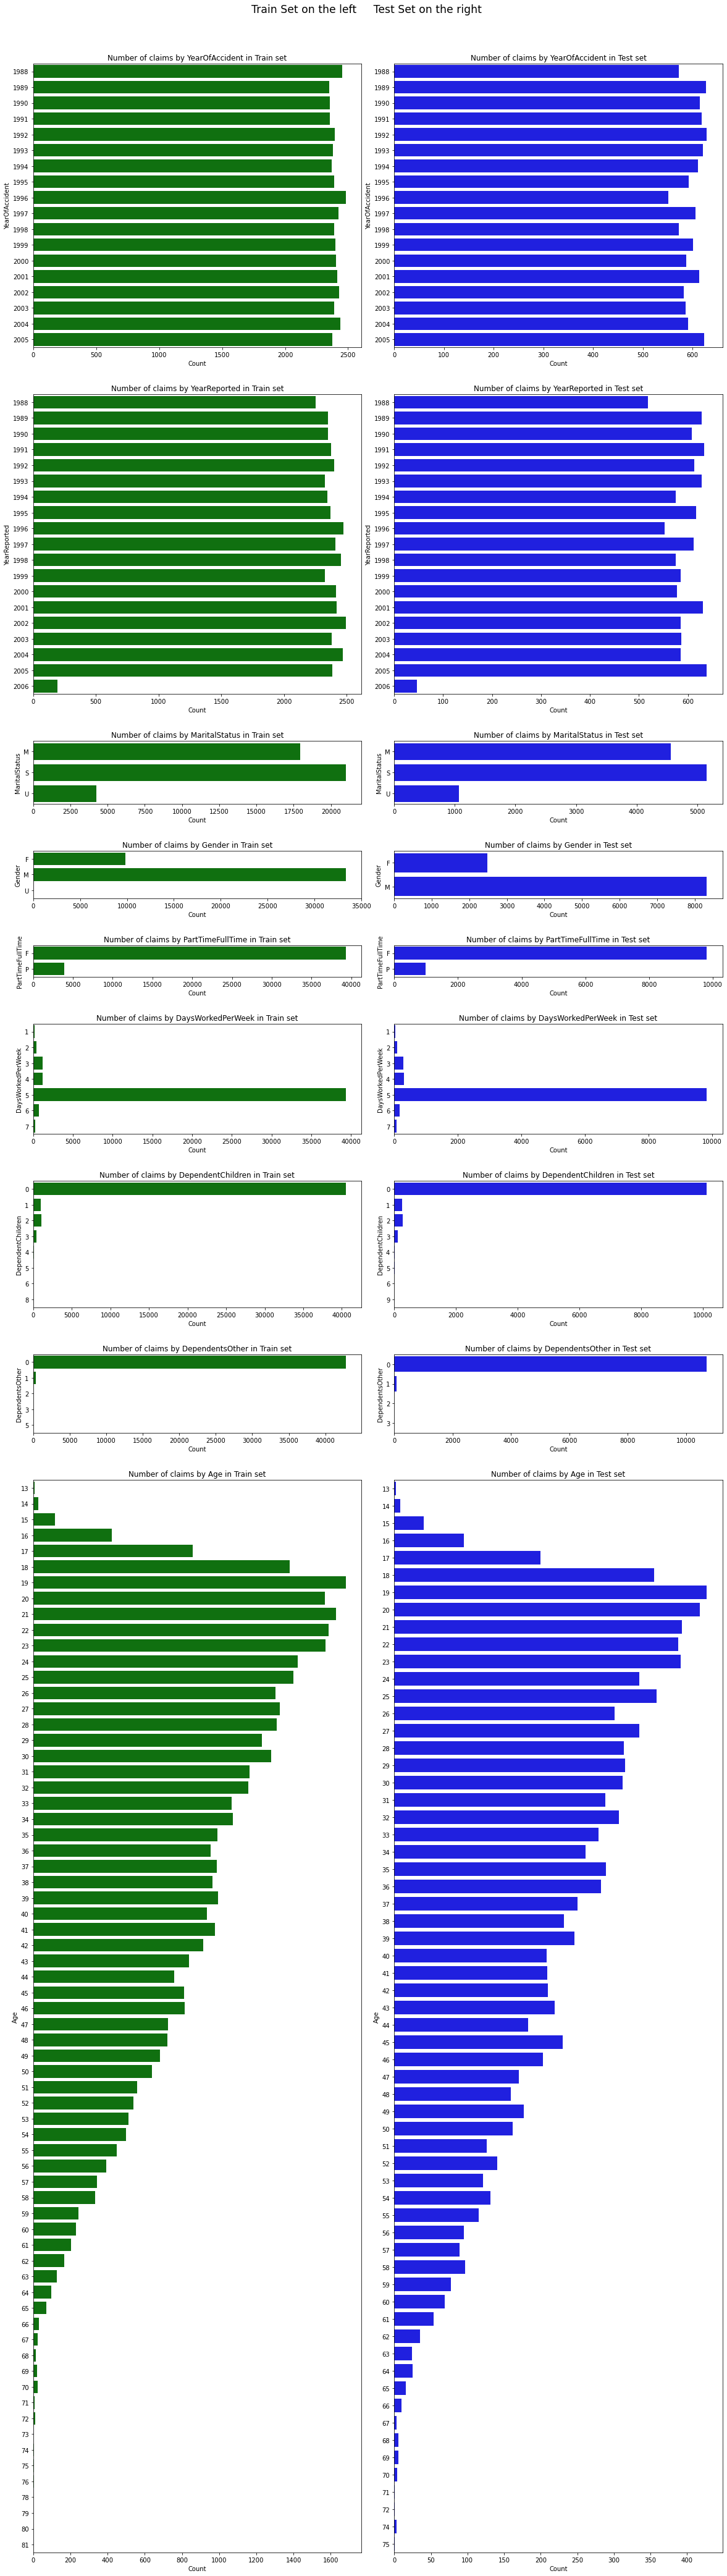

In [319]:
for df in [train_set, test_set]:
    df['YearOfAccident']  = pd.DatetimeIndex(df['DateTimeOfAccident']).year
    df['YearReported']  = pd.DatetimeIndex(df['DateReported']).year

features_to_check = ['YearOfAccident', "YearReported", "MaritalStatus", "Gender", "PartTimeFullTime"
        , "DaysWorkedPerWeek", "DependentChildren", "DependentsOther", "Age"]
nrows = len(features_to_check)

# config size, number of rows ...
hsize = [] ; tot_hsize = 0
for i, f in enumerate(features_to_check):  # i: index tương ứng của f trong list
    hsize.append(len(train_set[f].unique()))
    tot_hsize += hsize[i]
    

fig = plt.figure(figsize = (20, .5*tot_hsize))
plt.subplots_adjust(hspace = 0.2, wspace = 0.1)

# https://matplotlib.org/3.3.3/tutorials/intermediate/gridspec.html
spec = fig.add_gridspec(nrows=nrows, ncols=2
            , width_ratios=[1, 1], height_ratios=hsize)

for i, f in enumerate(features_to_check):
    
    ax = fig.add_subplot(spec[i, 0])
    df_temp = train_set.groupby(f)["WeeklyWages"].count().reset_index()
    sns.barplot(x="WeeklyWages", y=f, orient='h', data=df_temp, color="green", ax=ax)
    plt.xlabel('Count')
    plt.title(f"Number of claims by {f} in Train set");
    
    ax = fig.add_subplot(spec[i, 1])
    df_temp = test_set.groupby(f)["WeeklyWages"].count().reset_index()
    sns.barplot(x="WeeklyWages", y=f, orient='h', data=df_temp, color="blue", ax=ax)
    plt.xlabel('Count')
    plt.title(f"Number of claims by {f} in Test set");
    
fig.subplots_adjust(top=0.96)
fig.suptitle("Train Set on the left     Test Set on the right", fontsize="xx-large");

#### transform text

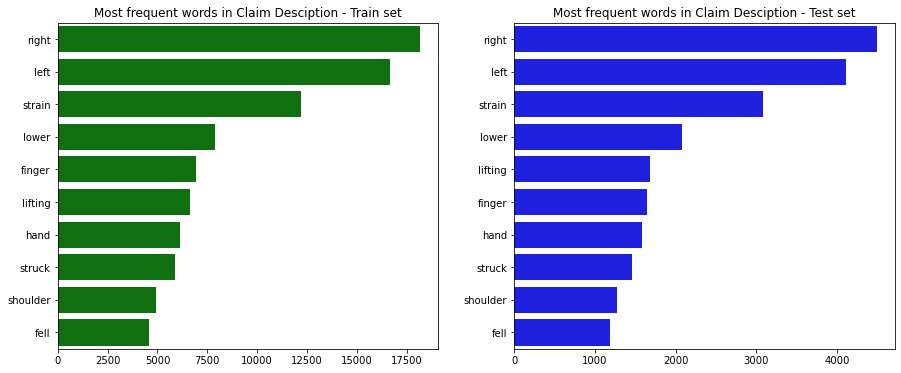

In [320]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
fig, ax = plt.subplots(figsize=(15, 6))

ax = plt.subplot(1, 2, 1)
vect = CountVectorizer(min_df = 50, stop_words = "english").fit(train_set["ClaimDescription"])
claimdesc = vect.transform(train_set["ClaimDescription"])
stat_voc = pd.Series({f:n for f, n in zip(vect.get_feature_names(), claimdesc.sum(axis=0).tolist()[0])}).sort_values(ascending=False)
sns.barplot(y=stat_voc.index[:10], x=stat_voc.values[:10], orient='h', color = "green", ax=ax)
ax.set_title("Most frequent words in Claim Desciption - Train set");

ax = plt.subplot(1, 2, 2)
vect = CountVectorizer(min_df = 50, stop_words = "english").fit(test_set["ClaimDescription"])
claimdesc = vect.transform(test_set["ClaimDescription"])
stat_voc = pd.Series({f:n for f, n in zip(vect.get_feature_names(), claimdesc.sum(axis=0).tolist()[0])}).sort_values(ascending=False)
sns.barplot(y=stat_voc.index[:10], x=stat_voc.values[:10], orient='h', color = "blue", ax=ax)
ax.set_title("Most frequent words in Claim Desciption - Test set");

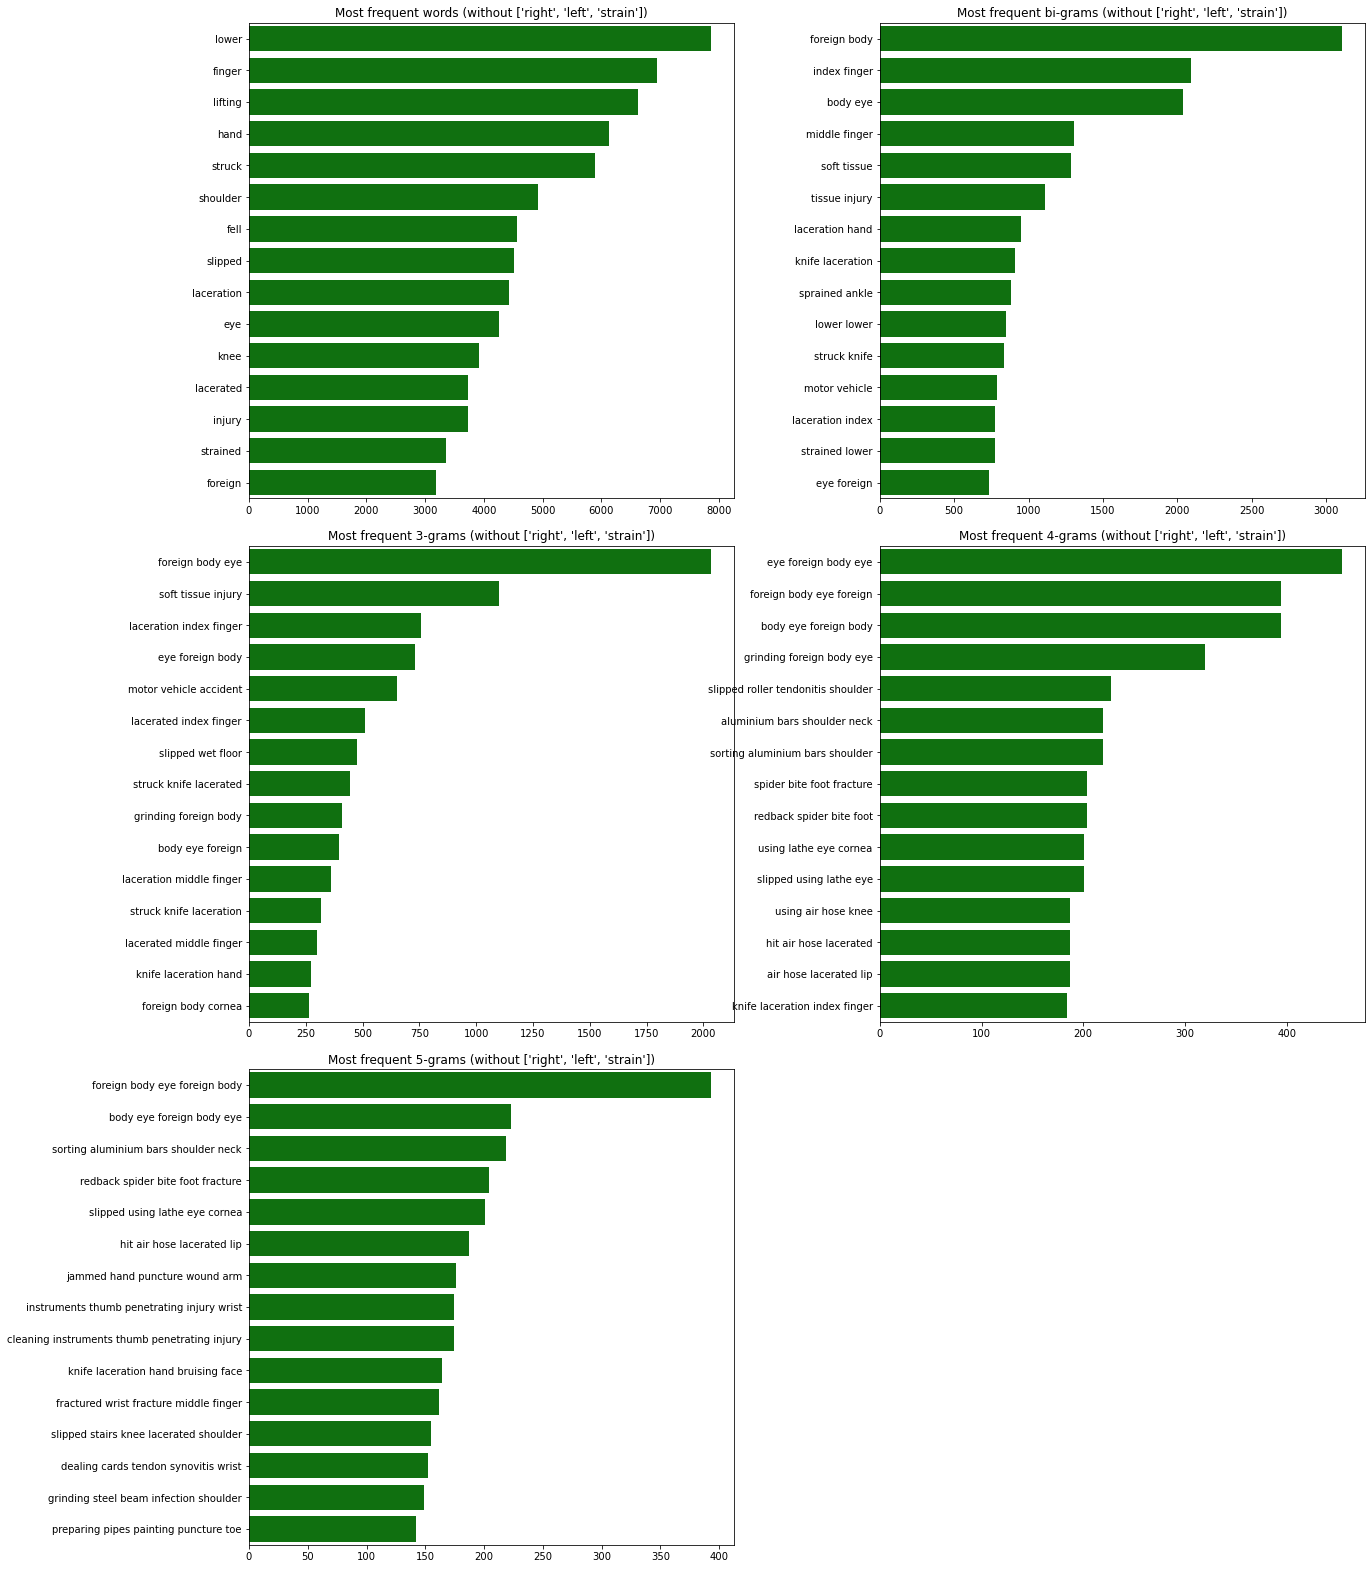

In [321]:
# do là bảo hiểm nhân thọ nên những từ (bên trái, phải,..) rất thường xuyên và không ảnh hưởng đến Tiền bảo hiểm 
stop_words = ENGLISH_STOP_WORDS.union(["right", "left", "strain"])


most_frequent = 15

fig, ax = plt.subplots(figsize=(20, 28))
plt.subplots_adjust(hspace = 0.1, wspace = 0.3)

ax = plt.subplot(3, 2, 1)
vect = CountVectorizer(min_df = 50, stop_words = stop_words).fit(train_set["ClaimDescription"])
claimdesc = vect.transform(train_set["ClaimDescription"])
features_names = vect.get_feature_names()
stat_voc = pd.Series({f:n for f, n in zip(features_names, claimdesc.sum(axis=0).tolist()[0])})
stat_voc.sort_values(ascending=False, inplace=True)
sns.barplot(y=stat_voc.index[:most_frequent], x=stat_voc.values[:most_frequent], orient='h', ax=ax, color="green")
plt.title("Most frequent words (without ['right', 'left', 'strain'])");

ax = plt.subplot(3, 2, 2)
vect = CountVectorizer(ngram_range=(2, 2), min_df = 10, stop_words = stop_words).fit(train_set["ClaimDescription"])
claimdesc = vect.transform(train_set["ClaimDescription"])
features_names = vect.get_feature_names()
stat_voc = pd.Series({f:n for f, n in zip(features_names, claimdesc.sum(axis=0).tolist()[0])})
stat_voc.sort_values(ascending=False, inplace=True)
sns.barplot(y=stat_voc.index[:most_frequent], x=stat_voc.values[:most_frequent], orient='h', ax=ax, color="green")
plt.title("Most frequent bi-grams (without ['right', 'left', 'strain'])");

ax = plt.subplot(3, 2, 3)
vect = CountVectorizer(ngram_range=(3, 3), min_df = 10, stop_words = stop_words).fit(train_set["ClaimDescription"])
claimdesc = vect.transform(train_set["ClaimDescription"])
features_names = vect.get_feature_names()
stat_voc = pd.Series({f:n for f, n in zip(features_names, claimdesc.sum(axis=0).tolist()[0])})
stat_voc.sort_values(ascending=False, inplace=True)
sns.barplot(y=stat_voc.index[:most_frequent], x=stat_voc.values[:most_frequent], orient='h', ax=ax, color="green")
plt.title("Most frequent 3-grams (without ['right', 'left', 'strain'])");

ax = plt.subplot(3, 2, 4)
vect = CountVectorizer(ngram_range=(4, 4), min_df = 10, stop_words = stop_words).fit(train_set["ClaimDescription"])
claimdesc = vect.transform(train_set["ClaimDescription"])
features_names = vect.get_feature_names()
stat_voc = pd.Series({f:n for f, n in zip(features_names, claimdesc.sum(axis=0).tolist()[0])})
stat_voc.sort_values(ascending=False, inplace=True)
sns.barplot(y=stat_voc.index[:most_frequent], x=stat_voc.values[:most_frequent], orient='h', ax=ax, color="green")
plt.title("Most frequent 4-grams (without ['right', 'left', 'strain'])")

ax = plt.subplot(3, 2, 5)
vect = CountVectorizer(ngram_range=(5, 5), min_df = 10, stop_words = stop_words).fit(train_set["ClaimDescription"])
claimdesc = vect.transform(train_set["ClaimDescription"])
features_names = vect.get_feature_names()
stat_voc = pd.Series({f:n for f, n in zip(features_names, claimdesc.sum(axis=0).tolist()[0])})
stat_voc.sort_values(ascending=False, inplace=True)
sns.barplot(y=stat_voc.index[:most_frequent], x=stat_voc.values[:most_frequent], orient='h', ax=ax, color="green")
plt.title("Most frequent 5-grams (without ['right', 'left', 'strain'])");

## Now, cleaning data
And dates transformation

In [322]:
for df in [train_set, test_set]:
    
    # Date Accident transformation
    df['MonthOfAccident']  = pd.DatetimeIndex(df['DateTimeOfAccident']).month
    df['DayOfAccident']  = pd.DatetimeIndex(df['DateTimeOfAccident']).day
    df['WeekdayOfAccident']  = pd.DatetimeIndex(df['DateTimeOfAccident']).day_name()
    df['HourOfAccident']  = pd.DatetimeIndex(df['DateTimeOfAccident']).hour
        
    # About reported data
    df['WeekdayOfReported']  = pd.DatetimeIndex(df['DateReported']).day_name()
        
    # Reporting delay of report in days
    df['DaysReportDelay'] = pd.DatetimeIndex(df['DateReported']).date - pd.DatetimeIndex(df['DateTimeOfAccident']).date
    df['DaysReportDelay'] = (df['DaysReportDelay']  / np.timedelta64(1, 'D')).astype(int)
    
    # ReportedDate : in the same year than YearOfAccident or not ?
    df["YearReportDelay"] = df['YearReported'] - df['YearOfAccident']
    df["YearReportDelay"].clip(0, 1, inplace=True)
    
    # Clip extrems values
    df["DependentsOther"].clip(0, 1, inplace=True)
    df["DependentChildren"].clip(0, 3, inplace = True)
    df["Age"].clip(14, 75, inplace = True)
    df["Gender"].replace({"U":"M"}, inplace = True)  # thay unknown bằng men vì men phổ biến hơn
    df["MaritalStatus"].fillna("S", inplace = True)

        
    df.loc[df["HoursWorkedPerWeek"] > 168, "HoursWorkedPerWeek"] = -1     # 168 = 7 * 24, tuần làm nhiều hơn 7 ngày -> data sai
    
        
train_set[[f for f in train_set.columns if f != "ClaimDescription"]].head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredCalimsCost,UltimateIncurredClaimCost,YearOfAccident,YearReported,MonthOfAccident,DayOfAccident,WeekdayOfAccident,HourOfAccident,WeekdayOfReported,DaysReportDelay,YearReportDelay
ClaimNumber,,,,,,,,,,,,,,,,,,,,,,
WC2128955,1989-08-22T16:00:00Z,1989-09-05T00:00:00Z,53,M,S,0,0,320.13,F,38.0,5,1400,1271.460989,1989,1989,8,22,Tuesday,16,Tuesday,14,0
WC6859105,1999-09-08T12:00:00Z,1999-10-25T00:00:00Z,28,M,M,0,0,728.60,F,60.0,5,1500,6458.616128,1999,1999,9,8,Wednesday,12,Monday,47,0
WC8650267,2003-04-01T13:00:00Z,2003-06-25T00:00:00Z,29,M,S,0,0,555.07,F,38.0,5,10000,7704.364284,2003,2003,4,1,Tuesday,13,Wednesday,85,0
WC6969641,1999-03-19T16:00:00Z,1999-04-05T00:00:00Z,19,F,S,0,0,200.00,F,38.0,5,500,301.342059,1999,1999,3,19,Friday,16,Monday,17,0
WC2269854,1989-03-28T12:00:00Z,1989-04-25T00:00:00Z,23,M,S,0,0,200.00,F,40.0,5,350,993.852022,1989,1989,3,28,Tuesday,12,Tuesday,28,0


In [323]:
train_set.Gender.value_counts()
train_set.MaritalStatus.value_counts()

S    21024
M    17947
U     4229
Name: MaritalStatus, dtype: int64

# Part 3 : Feature Engineering / data preparation

## Label Encoder (for several columns at the same time)

In [325]:
# For several columns
class LabelEncoders(TransformerMixin, BaseEstimator): 
    
    def __init__(self, features=[]):
        self.features_ = features

    def fit(self, X, y=None):
        
        self.encoders_ = {}
        for f in self.features_:
            enc = LabelEncoder()
            self.encoders_[f] = enc.fit(X[f])

        return self
    
    def transform(self, X):
        
        df = X.copy()
        
        for f in self.features_:
            df[f] = self.encoders_[f].transform(df[f])
        
        return df

LE = LabelEncoders(["MaritalStatus", "Gender"])
LE.fit(train_set)
X_tr = LE.transform(train_set)
X_tr[["MaritalStatus", "Gender"]].head()

,MaritalStatus,Gender
ClaimNumber,,
WC2128955,1,1
WC6859105,0,1
WC8650267,1,1
WC6969641,1,0
WC2269854,1,1


## Transformation of monetary features
Log transformation, because of extreme values  
Standardize transformation by year, because of inflation 

In [326]:
class Log_StdScaler_ByGroup(TransformerMixin, BaseEstimator):
    
    '''
    Transformer for continous feature
    
    Compute log of original feature
    Compute mean and std for the feature for every group of another feature
    Standardize the feature for every group
    
    The transformer will be fit on a train set
    and it can transform another dataset 
   
    '''
    
    def __init__(self, groupby="YearOfAccident", feature = 'UltimateIncurredClaimCost'
            , stdscal = True, log = np.log1p, trunc_UltimateIncurredClaimCost = True
            , verbose = False):
        '''
        np.log1p(x) = np.log(1+x)  ## tránh không xác định?
        '''
        self.groupby = groupby

        self.feature = feature
        self.log = log
        self.stdscal = stdscal
        self.trunc_UltimateIncurredClaimCost = trunc_UltimateIncurredClaimCost
                
        self.verbose = verbose
        
    def fit(self, X, y=None):
        
        df_temp = X[[self.groupby, self.feature]].copy()
        if self.verbose: print("Initial situation : \n", X_tr[[self.groupby, self.feature]].head())
            
        if self.trunc_UltimateIncurredClaimCost and self.feature == 'UltimateIncurredClaimCost':
            df_temp[self.feature].clip(0, 900000, inplace=True)
        
        if not self.log is None:
            df_temp[self.feature] = self.log(df_temp[self.feature])
            
        self.df_stats = df_temp.groupby(self.groupby)[self.feature].agg(["mean", "std"]).reset_index()
        if self.verbose: print("\nFit :\n",self.df_stats)
        
        return self
    
    def transform(self, X):
        
        if self.verbose: print("Initial situation : \n", X[[self.groupby, self.feature]].head())

        df = X.merge(self.df_stats, how="left", on = self.groupby)
            
        if self.trunc_UltimateIncurredClaimCost and self.feature == 'UltimateIncurredClaimCost':
            df[self.feature] = df[self.feature].clip(0, 900000)

        if not self.log is None:
            df[self.feature] = self.log(df[self.feature])
            
        if self.stdscal:
            df[self.feature] = (df[self.feature] - df["mean"]) / df["std"]
            
        df.drop(["mean", "std"], axis=1, inplace = True)
        
        if self.verbose: print("\nAfter transf :\n",df[[self.groupby, self.feature]].head())
            
        return df
    
    def inverse_transform(self, X):
        
        df = X.merge(self.df_stats, how="left", on = self.groupby)
        if self.stdscal:
            df[self.feature] = df[self.feature] * df["std"] + df["mean"] 
        df.drop(["mean", "std"], axis=1, inplace = True)
            
        if self.log == np.log:
            df[self.feature] = np.exp(df[self.feature])
        if self.log == np.log1p:
            df[self.feature] = np.exp(df[self.feature]) - 1

        if self.verbose: print("\nAfter inverse transf :\n",df[[self.groupby, self.feature]].head())
        if self.verbose: print(df.columns)
            
        return df

logstd = Log_StdScaler_ByGroup(verbose=True, feature = "InitialIncurredCalimsCost")
logstd.fit(X_tr)
df_temp = logstd.transform(train_set)
df_temp = logstd.inverse_transform(df_temp)

del df_temp

Initial situation : 
              YearOfAccident  InitialIncurredCalimsCost
ClaimNumber                                           
WC2128955              1989                       1400
WC6859105              1999                       1500
WC8650267              2003                      10000
WC6969641              1999                        500
WC2269854              1989                        350

Fit :
     YearOfAccident      mean       std
0             1988  7.390070  1.232242
1             1989  7.244098  1.170577
2             1990  7.207496  1.118622
3             1991  7.322472  1.134717
4             1992  7.429245  1.205994
5             1993  7.648827  1.300652
6             1994  7.730141  1.362015
7             1995  7.311501  1.447212
8             1996  7.477049  1.443849
9             1997  7.639602  1.504933
10            1998  7.754106  1.599483
11            1999  7.867616  1.526537
12            2000  8.143436  1.589601
13            2001  8.333841  1.643832


## About log transformation of target

In [327]:
def create_y_true(X_trn, X_val, y_param):

    df_y_trn = X_trn[[y_param["groupby"], "UltimateIncurredClaimCost"]].copy()  # df_y_trn: YearOfAccident,UltimateIncurredClaimCost,ClaimNumber                                         
    df_y_val = X_val[[y_param["groupby"], "UltimateIncurredClaimCost"]].copy()
 
    y_logstd = Log_StdScaler_ByGroup(**y_param).fit(df_y_trn)
    y_trn = y_logstd.transform(df_y_trn)["UltimateIncurredClaimCost"].values
    y_val = y_logstd.transform(df_y_val)["UltimateIncurredClaimCost"].values
        
    for df in [df_y_trn, df_y_val]:
        df.rename({"UltimateIncurredClaimCost":"y_true"}, inplace = True, axis = 1)
            
    return y_trn, y_val, df_y_trn, df_y_val, y_logstd
            
def transform_y_pred(y_pred, df_y, y_logstd):
    
    df_y["UltimateIncurredClaimCost"] = y_pred
    df_y = y_logstd.inverse_transform(df_y)
    
    rmse_ = None
    if "y_true" in df_y.columns:
        rmse_ = rmse(df_y["y_true"], df_y["UltimateIncurredClaimCost"])
    
    return df_y["UltimateIncurredClaimCost"].values, rmse_
    
        
y_param = {"groupby" : "YearOfAccident", "feature" : 'UltimateIncurredClaimCost'
            , "stdscal" : True, "log" : np.log, "trunc_UltimateIncurredClaimCost" : False
            , "verbose" : False}

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_set, train_set[y_param["groupby"]])):
        
    X_trn, X_val = train_set.iloc[trn_idx], train_set.iloc[val_idx]
    y_trn, y_val, df_y_trn, df_y_val, y_logstd = create_y_true(X_trn, X_val, y_param)
    
    y_values, rmse_ = transform_y_pred(y_val, df_y_val, y_logstd)
    print(f"RMSE (pred = true) (orginal = inverse tranform ?): {rmse_:.3f}")
    
    y_values, rmse_ = transform_y_pred(y_val + 1, df_y_val, y_logstd)
    print(f"RMSE (log pred = 1 + log true) : {rmse_:,.0f}")

RMSE (pred = true) (orginal = inverse tranform ?): 0.000
RMSE (log pred = 1 + log true) : 199,437
RMSE (pred = true) (orginal = inverse tranform ?): 0.000
RMSE (log pred = 1 + log true) : 114,336
RMSE (pred = true) (orginal = inverse tranform ?): 0.000
RMSE (log pred = 1 + log true) : 108,393
RMSE (pred = true) (orginal = inverse tranform ?): 0.000
RMSE (log pred = 1 + log true) : 109,908
RMSE (pred = true) (orginal = inverse tranform ?): 0.000
RMSE (log pred = 1 + log true) : 104,669


## Count vectorizer - ClaimDescription
Fit a regressor with ClaimDescription only, a score.

In [328]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
print(tokenizer.tokenize("The Sky is blue, also the ocean is blue also Rainbow has a blue colour."))

from nltk.corpus import stopwords 
__stop_words = stopwords.words('english') # Selecting english stopwords

# Lemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from sklearn.linear_model import Ridge

['The', 'Sky', 'is', 'blue', 'also', 'the', 'ocean', 'is', 'blue', 'also', 'Rainbow', 'has', 'a', 'blue', 'colour']


In [329]:
def drop_duplicates_token(doc):
    ordered_tokens = set()
    result = []
    for word in doc:
        if word not in ordered_tokens:
            ordered_tokens.add(word)
            result.append(word)
    return result
doc = "The Sky is blue, also the ocean is blue also Rainbow has a blue colour."
print(drop_duplicates_token(tokenizer.tokenize(doc)))

['The', 'Sky', 'is', 'blue', 'also', 'the', 'ocean', 'Rainbow', 'has', 'a', 'colour']


In [330]:
%%time
class ClaimDesciptionScore(TransformerMixin, BaseEstimator): 
    def __init__(self, regressor, stop_words, lemmatizer = None, drop_duplicates_words = True
                 , ngram_range=(1, 6), min_df=100, return_score = False, verbose = False):
        
        self.regressor = regressor
        self.stop_words = stop_words
        self.ngram_range = ngram_range
        self.drop_duplicates_words = drop_duplicates_words
        self.min_df = min_df
        self.lemmatizer = lemmatizer
        self.return_score = return_score
        self.verbose = verbose
        
    def prepare_data(self, X):
        
        docs = X["ClaimDescription"].copy()
        
        # Tokenize all docs
        docs = [tokenizer.tokenize(doc.lower()) for doc in docs]
        
        # Remove words that are only one character.
        docs = [[token for token in doc if len(token) > 1] for doc in docs]

        # Remove stopwords
        docs = [[token for token in doc if token not in self.stop_words] for doc in docs]

        # Lemmatize the documents.
        if self.lemmatizer == "WordNet":
            docs = [[WordNetLemmatizer().lemmatize(token) for token in doc] for doc in docs]
            
        # Drop duplicates words
        if self.drop_duplicates_words:
            docs = [drop_duplicates_token(doc) for doc in docs]
            
        docs = [' '.join(doc) for doc in docs]
        
        return docs
        

    def fit(self, X, y=None):
        
        docs = self.prepare_data(X)
        
        self.vect = CountVectorizer(ngram_range=self.ngram_range, min_df = self.min_df).fit(docs)  # sử dụng count vectorizer để chuyển về dạng vector
        X_trn = self.vect.transform(docs)
        features_names = self.vect.get_feature_names()
        
        df_y_trn = X[["YearOfAccident", "UltimateIncurredClaimCost"]].copy()
        self.y_logstd = Log_StdScaler_ByGroup(groupby="YearOfAccident", feature='UltimateIncurredClaimCost'
            , stdscal=True, log=np.log1p, trunc_UltimateIncurredClaimCost=True
            , verbose=False).fit(df_y_trn)
        y_trn = self.y_logstd.transform(df_y_trn)["UltimateIncurredClaimCost"].values
        df_y_trn.rename({"UltimateIncurredClaimCost":"y_true"}, inplace = True, axis = 1)
        
        self.regressor.fit(X_trn, y_trn)
        
        if self.verbose:
            print(self.regressor.coef_)
            print(self.vect.get_feature_names())
        
        return self
    
    def transform(self, X):
        
        df = X.copy()
        docs = self.prepare_data(X)
        X_val = self.vect.transform(docs)
        
        df["ClaimDescriptionScore"] = self.regressor.predict(X_val)
        
        rmse_ = None
        if self.return_score and "UltimateIncurredClaimCost" in X.columns:
            df_y_val = X[["YearOfAccident", "UltimateIncurredClaimCost"]].copy()
            y_val = self.y_logstd.transform(df_y_val)["UltimateIncurredClaimCost"].values
            df_y_val.rename({"UltimateIncurredClaimCost":"y_true"}, inplace = True, axis = 1)
            
            y_values, rmse_ = transform_y_pred(df["ClaimDescriptionScore"].values, df_y_val, y_logstd)
            if self.verbose: print("RMSE : {:,.0f}".format(rmse_))
        
            return df, rmse_
        else:
            return df

CPU times: user 41 µs, sys: 0 ns, total: 41 µs
Wall time: 45.1 µs


In [331]:
import itertools
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))

??

In [332]:
%%time
grid_params={"alpha":[.001, .01, .1, 1], "lemmatizer":[None, "WordNet"]
             , 'ngram_range':[(1, 4), (1, 5), (1, 6), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 6)]
             , 'drop_duplicates_words':[True, False]}

# Best params are :
grid_params={"alpha":[.1], "lemmatizer":[None]
             , 'ngram_range':[(1, 5)]
             , 'drop_duplicates_words':[True]}

results=[]
for i, p in enumerate(product_dict(**grid_params)):
    
    scores = []
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_set, train_set["YearOfAccident"])):
        ClaimDescScore = ClaimDesciptionScore(regressor = Ridge(alpha=p["alpha"]), stop_words = __stop_words
            , lemmatizer=p["lemmatizer"], ngram_range=p["ngram_range"]
            , drop_duplicates_words=p["drop_duplicates_words"], return_score = True)
        _ = ClaimDescScore.fit(train_set.iloc[trn_idx])
        _, rmse_ = ClaimDescScore.transform(train_set.iloc[val_idx])
        scores.append(rmse_)
        
    p["rmse_"] = np.mean(scores)
    results.append(p)
res = pd.DataFrame.from_dict(results)

best_params_ = res.loc[res["rmse_"]==res["rmse_"].min()].to_dict(orient="records")
print(best_params_)
res

[{'alpha': 0.1, 'lemmatizer': None, 'ngram_range': (1, 5), 'drop_duplicates_words': True, 'rmse_': 32122.702181331046}]
CPU times: user 20.1 s, sys: 0 ns, total: 20.1 s
Wall time: 20.1 s


,alpha,lemmatizer,ngram_range,drop_duplicates_words,rmse_
0,0.1,None,"(1, 5)",True,32122.702181


## Topics in ClaimDescription : LDA_model with gensin
https://www.kaggle.com/tanguypledel/topic-modeling-lda-implementation/data  
Tanguy Pledel

I add parallelize run to go faster during transformation. And I've written a transformer.

In [333]:
import psutil
__n_cores = psutil.cpu_count()     # Available CPU cores
print(f"N Cores : {__n_cores}")
from multiprocessing import Pool   # Multiprocess Runs

def df_parallelize_run(func, t_split):
    
    num_cores = np.min([__n_cores, len(t_split)])
    pool = Pool(num_cores)
    df = pool.map(func, t_split)
    pool.close()
    pool.join()
    
    return df

N Cores : 4


In [334]:
# Importing libraries
import gensim # open-source library for unsupervised topic modeling and NLP
from gensim.utils import simple_preprocess

import gensim.corpora as corpora
from pprint import pprint

In [335]:
class search_dominant_topic(TransformerMixin, BaseEstimator):
    
    def __init__(self, num_topics=10, more_stop_words=["left", "right", "strain"]
                 , seed=0, verbose = False, n_jobs=4):
        
        self.num_topics = num_topics
        self.verbose = verbose
        self.seed = seed
        
        self.more_stop_words = more_stop_words
        self.stop_words = stopwords.words('english')
        self.stop_words.extend(['from', 'subject', 're', 'edu', 'use'] + self.more_stop_words) # adding new stopwords
        
        # Lists of new features by category
        self.feats_categorical = [f"word_{f}_in_description" for f in self.more_stop_words] + [f"max_topic_{i+1}" for i in range(self.num_topics)]
        self.feats_continous = [f"topic_{i}" for i in range(self.num_topics)]
        
        self.n_jobs=n_jobs
        
    def prepare_docs(self, X):
        
        docs = X["ClaimDescription"].values.tolist()
        
        # Split the documents into tokens.
        tokenizer = RegexpTokenizer(r'\w+')
        
        # Convert to lowercase,  and split into words.
        docs = [tokenizer.tokenize(doc.lower()) for doc in docs]
        
        # Remove words that are only one character.
        docs = [[token for token in doc if len(token) > 1] for doc in docs]

        # Remove stopwords
        docs = [[token for token in doc if token not in stop_words] for doc in docs]

        # Lemmatizer 
        lemmatizer = WordNetLemmatizer()
        docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
        
        return docs

        
    def fit(self, X, y=None):
        
        docs = self.prepare_docs(X)
        
        # Create a dictionary representation of the documents.
#        dictionary = Dictionary(docs)
        self.id2word = corpora.dictionary.Dictionary(docs)
        
        # Filter out words that occur less than 10 documents, or more than 30% of the documents.
        self.id2word.filter_extremes(no_below=10, no_above=0.3)

        # Bag-of-words representation of the documents.
        corpus = [self.id2word.doc2bow(doc) for doc in docs]

        self.lda_model = gensim.models.LdaMulticore(corpus = corpus,
                id2word = self.id2word,
                num_topics = self.num_topics,
                random_state = self.seed)
        
        # Print the Keyword in the 10 topics
        if self.verbose: pprint(lda_model.print_topics())
            
        return self
    
    def transform_a_part(self, X):
    
        docs = self.prepare_docs(X)
        
        # Term Document Frequency
        # Converts a collection of words to a list of (word_id, word_frequency) 2-tuples.
        corpus = [self.id2word.doc2bow(text) for text in docs]
        
        ll = list(self.lda_model[corpus])
        for i, l in enumerate(ll):
            for a in range(len(l), self.num_topics):
                ll[i].append((-1, -1))
        df = pd.DataFrame(ll)
        
        for i in range(self.num_topics):
            df[[f"_{i}", f"topic_{i}"]] = pd.DataFrame(df[i].tolist())    
        
        cols = [f"topic_{i}" for i in range(self.num_topics)]
        
        df["sorted_topics"] = df[cols].apply(lambda s: s.nlargest(2).index.tolist(), axis=1)
        df[[f"max_topic_{i+1}" for i in range(2)]] = pd.DataFrame(df["sorted_topics"].tolist()) 
        for i in range(2):
            df[f"max_topic_{i+1}"] = df[f"max_topic_{i+1}"].str[6:].fillna(-1).astype(np.int8)
        
        df.fillna(-1, inplace=True)

        cols = cols + [f"max_topic_{i+1}" for i in range(2)]
        
        df = pd.concat([X.reset_index(), df[cols]], axis=1).set_index("ClaimNumber")
        
        for f in self.more_stop_words:
        
            df[f"word_{f}_in_description"] = df["ClaimDescription"].str.lower()
            df[f"word_{f}_in_description"] = df[f"word_{f}_in_description"].str.contains(f)
        
        return df
    
    def transform(self, X):
        
        N = X.shape[0]
        
        # Split X in p parts, p is the number of cores
        df_temp = [X[int(N * p / self.n_jobs):int(N * (p + 1)/self.n_jobs)] for p in range(self.n_jobs)]
        
        # Transform each part
        return pd.concat(df_parallelize_run(self.transform_a_part, df_temp))

In [336]:
%%time
res={}

for nt in [6]:
    sdt = search_dominant_topic(num_topics = nt, seed=__seed)
    _ = sdt.fit(train_set)
    X_tr = sdt.transform(train_set)
    
    res[nt]=[]
    a = X_tr["max_topic_1"].value_counts()
    res[nt].append(a[a.index!=-1].min())
    
    cols = [f"topic_{i}" for i in range(nt)]

    X_tr["bis_sorted_topics"] = X_tr[cols].apply(lambda s: s.nlargest(2).tolist(), axis=1)
    val = abs(pd.DataFrame(X_tr["bis_sorted_topics"].tolist())[0] - pd.DataFrame(X_tr["bis_sorted_topics"].tolist())[1])
#    res[nt]["ecart<.1"] = val[val<.10].count()
    res[nt].append(val[val<.10].count())
    
pd.DataFrame.from_dict(res, orient='index')

CPU times: user 24 s, sys: 786 ms, total: 24.8 s
Wall time: 38.5 s


,0,1
6,5553,3442


In [337]:
%%time
sdt = search_dominant_topic(seed=__seed)
_ = sdt.fit(train_set)

CPU times: user 12.2 s, sys: 576 ms, total: 12.8 s
Wall time: 13 s


In [338]:
%%time
X_tr = sdt.transform(train_set)

CPU times: user 276 ms, sys: 251 ms, total: 527 ms
Wall time: 13.3 s


In [339]:
%%time
X_te = sdt.transform(test_set)

CPU times: user 110 ms, sys: 187 ms, total: 297 ms
Wall time: 3.67 s


## To drop useless columns

In [340]:
class drop_features(TransformerMixin, BaseEstimator):
    
    def __init__(self, drop_features=[]):
        
        self.drop_features = ['DateTimeOfAccident', 'DateReported', 'ClaimDescription',
                             "UltimateIncurredClaimCost"] + drop_features
        
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X):
        
        df = X[[f for f in X.columns if f not in self.drop_features]].copy()
            
        return df

# Part 4 : Data Description and check of some feature transformers

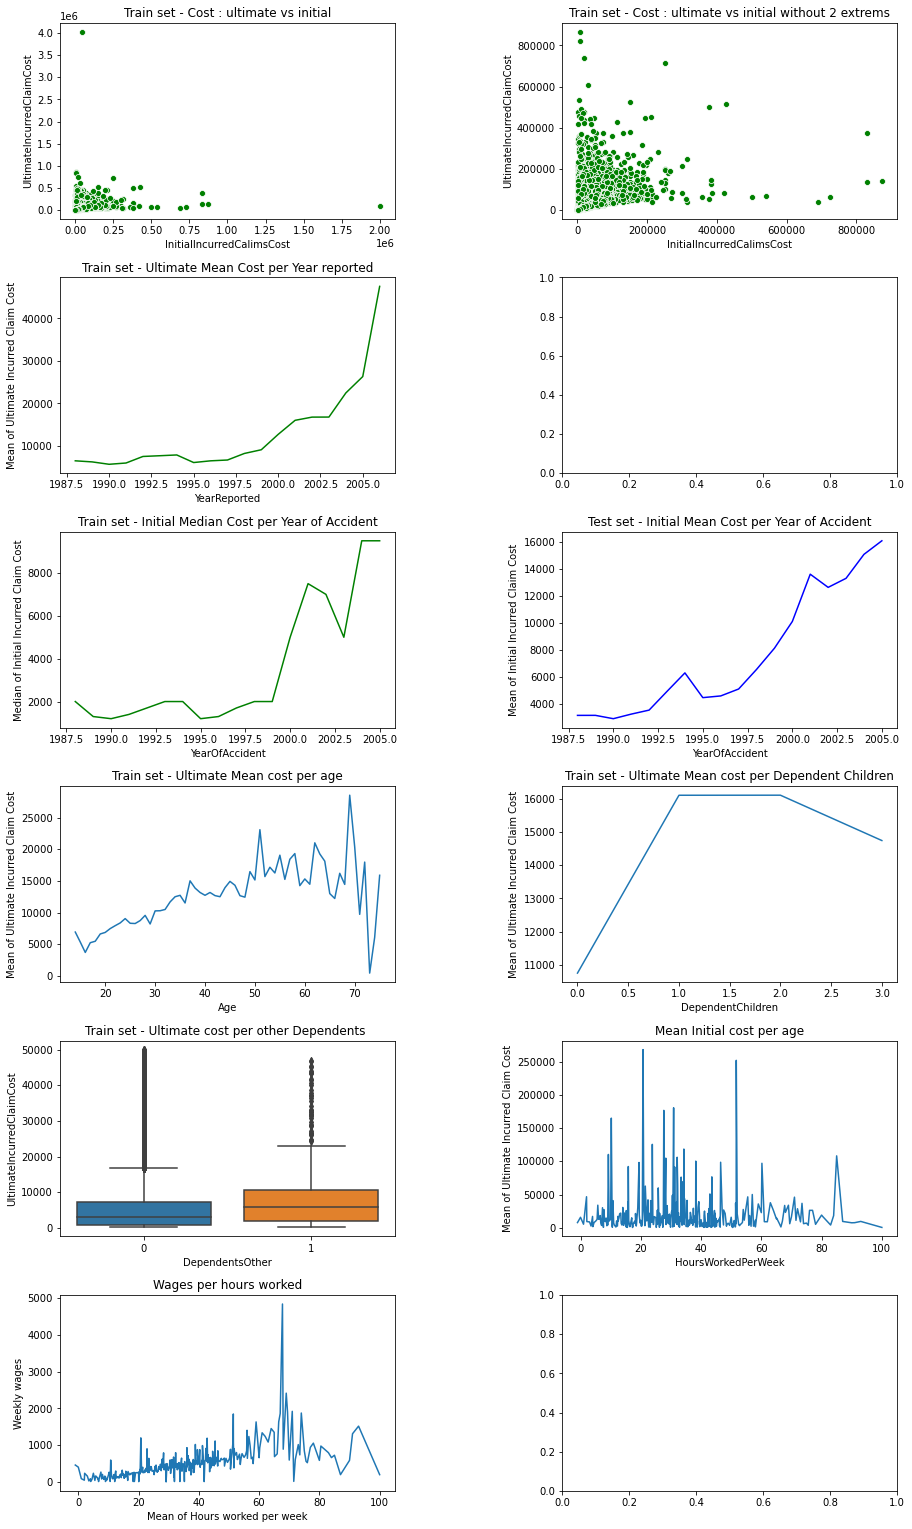

In [341]:
nrows, ncols = 6, 2
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(15, 4.5 * nrows))
plt.subplots_adjust(hspace = 0.3, wspace = 0.5)
    
ax = plt.subplot(nrows, ncols, 1)
sns.scatterplot(x=train_set["InitialIncurredCalimsCost"], y=train_set["UltimateIncurredClaimCost"], ax=ax, color="green")
ax.set_title("Train set - Cost : ultimate vs initial");

ax = plt.subplot(nrows, ncols, 2)
df_temp = train_set.loc[(train_set["InitialIncurredCalimsCost"]<1000000)&
                       (train_set["UltimateIncurredClaimCost"]<1000000)]
sns.scatterplot(x=df_temp["InitialIncurredCalimsCost"], y=df_temp["UltimateIncurredClaimCost"], ax=ax, color="green")
ax.set_title("Train set - Cost : ultimate vs initial without 2 extrems");

ax = plt.subplot(nrows, ncols, 3)
df_temp = train_set.groupby("YearReported")["UltimateIncurredClaimCost"].mean()
df_temp.plot(ax=ax, color="green")
plt.ylabel('Mean of Ultimate Incurred Claim Cost')
ax.set_title("Train set - Ultimate Mean Cost per Year reported");

ax = plt.subplot(nrows, ncols, 5)
df_temp = train_set.groupby("YearOfAccident")["InitialIncurredCalimsCost"].median()
df_temp.plot(ax=ax, color="green")
plt.ylabel('Median of Initial Incurred Claim Cost')
ax.set_title("Train set - Initial Median Cost per Year of Accident");

ax = plt.subplot(nrows, ncols, 6)
df_temp = test_set.groupby("YearOfAccident")["InitialIncurredCalimsCost"].mean()
df_temp.plot(ax=ax, color="blue")
plt.ylabel('Mean of Initial Incurred Claim Cost')
ax.set_title("Test set - Initial Mean Cost per Year of Accident");

ax = plt.subplot(nrows, ncols, 7)
df_temp = train_set.groupby("Age")["UltimateIncurredClaimCost"].mean()
df_temp.plot(ax=ax)
plt.ylabel('Mean of Ultimate Incurred Claim Cost')
ax.set_title("Train set - Ultimate Mean cost per age");

ax = plt.subplot(nrows, ncols, 8)
df_temp = train_set.groupby("DependentChildren")["UltimateIncurredClaimCost"].mean()
df_temp.plot(ax=ax)
plt.ylabel('Mean of Ultimate Incurred Claim Cost')
ax.set_title("Train set - Ultimate Mean cost per Dependent Children");

ax = plt.subplot(nrows, ncols, 9)
#df_temp = tr.groupby("DependentsOther")["UltimateIncurredClaimCost"].mean().to_frame().reset_index()
df_temp = train_set.loc[(train_set["UltimateIncurredClaimCost"]<50000)]
sns.boxplot(y="UltimateIncurredClaimCost", x="DependentsOther", data=df_temp, ax=ax)
ax.set_title("Train set - Ultimate cost per other Dependents ");

ax = plt.subplot(nrows, ncols, 10)
df_temp = train_set.groupby("HoursWorkedPerWeek")["UltimateIncurredClaimCost"].mean()
df_temp.plot(ax=ax)
plt.ylabel('Mean of Ultimate Incurred Claim Cost')
ax.set_title("Mean Initial cost per age");

ax = plt.subplot(nrows, ncols, 11)
df_temp = train_set.groupby("HoursWorkedPerWeek")["WeeklyWages"].mean()
df_temp.plot(ax=ax)
plt.ylabel('Weekly wages')
plt.xlabel('Mean of Hours worked per week')
ax.set_title("Wages per hours worked");


## Train and test comparison
There is no difference :

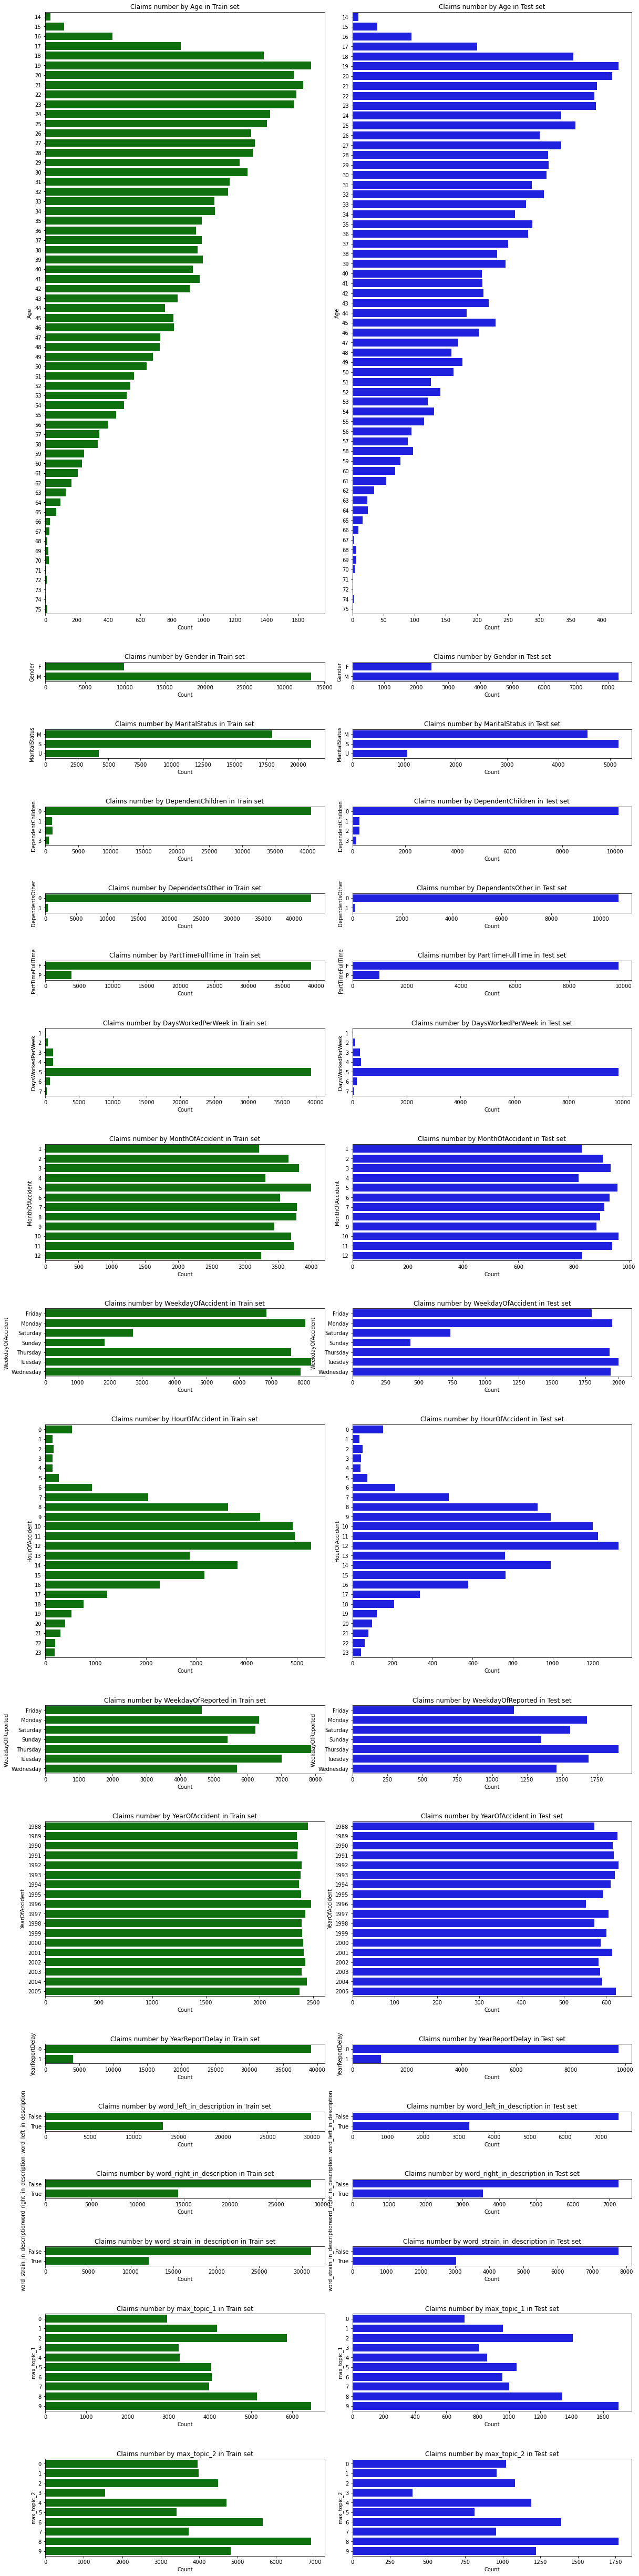

In [342]:
categorical_features = ['Age', 'Gender', 'MaritalStatus','DependentChildren', 'DependentsOther'
    , 'PartTimeFullTime', 'DaysWorkedPerWeek', 'MonthOfAccident', 'WeekdayOfAccident', 'HourOfAccident'
    , 'WeekdayOfReported', "YearOfAccident", "YearReportDelay"
    , "word_left_in_description", "word_right_in_description", "word_strain_in_description"] + \
    [f"max_topic_{i+1}" for i in range(2)]

nrows = len(categorical_features)

hsize = [] ; tot_hsize = 0
for i, f in enumerate(categorical_features):
    hsize.append(len(X_tr[f].unique()))
    tot_hsize += hsize[i]

fig = plt.figure(figsize = (20, .5 * tot_hsize))
plt.subplots_adjust(hspace = 0.5, wspace = 0.1)

# https://matplotlib.org/3.3.3/tutorials/intermediate/gridspec.html
spec = fig.add_gridspec(nrows=nrows, ncols=2
            , width_ratios=[1, 1], height_ratios=hsize)

for i, f in enumerate(categorical_features):
    
    ax = fig.add_subplot(spec[i, 0])
    df_temp = X_tr.groupby(f)["WeeklyWages"].count().reset_index()
    sns.barplot(x="WeeklyWages", y=f, orient='h', data=df_temp, color="green", ax=ax)
    plt.xlabel('Count')
    plt.title(f"Claims number by {f} in Train set")
    
    ax = fig.add_subplot(spec[i, 1])
    df_temp = X_te.groupby(f)["WeeklyWages"].count().reset_index()
    sns.barplot(x="WeeklyWages", y=f, orient='h', data=df_temp, color="blue")
    plt.xlabel('Count')
    plt.title(f"Claims number by {f} in Test set");

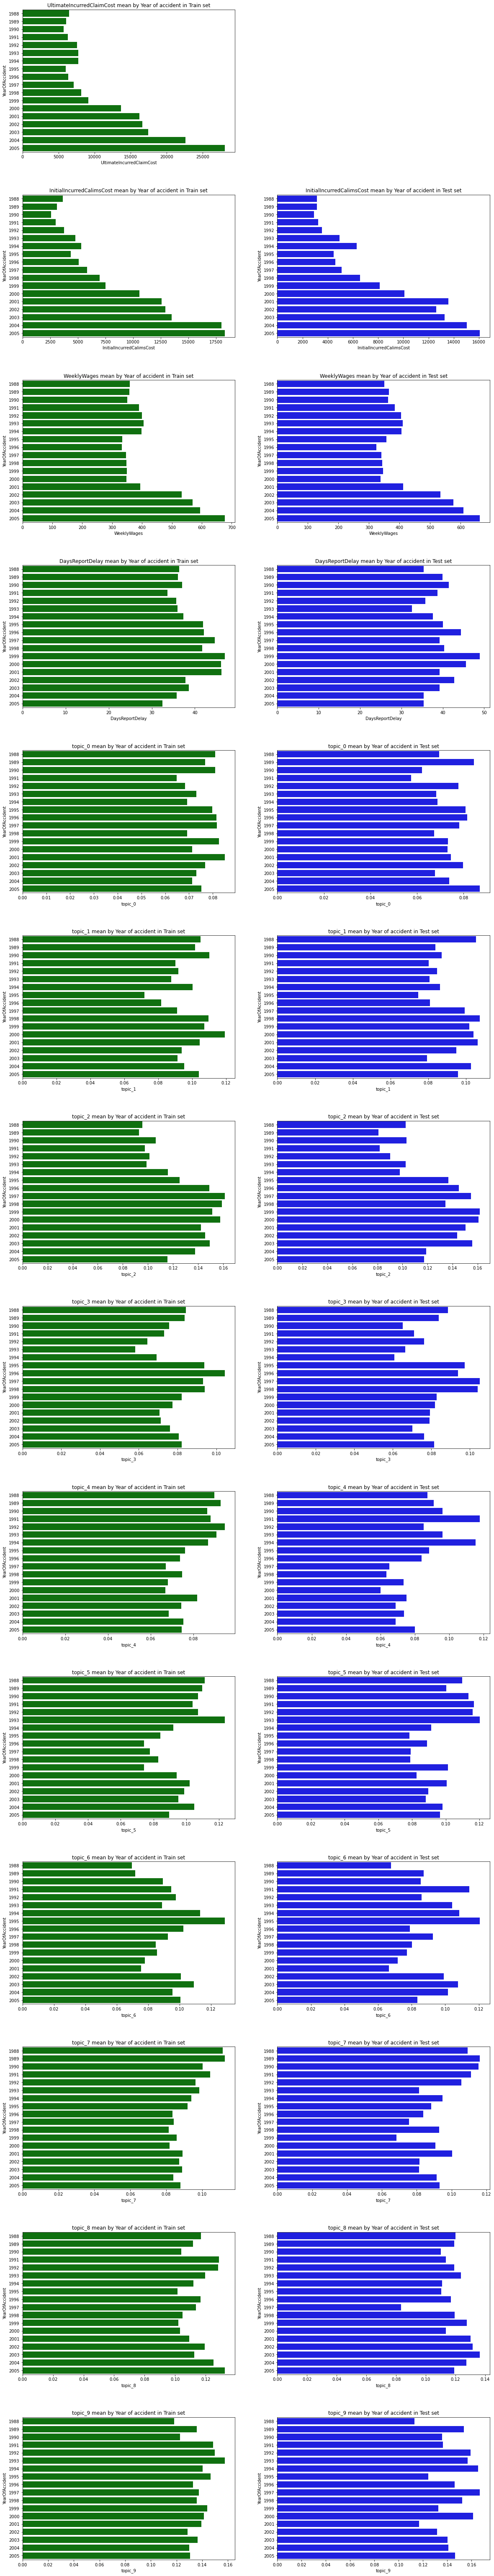

In [343]:
continous_features = ['UltimateIncurredClaimCost', 'InitialIncurredCalimsCost', 'WeeklyWages'
        , 'DaysReportDelay'] + [f"topic_{i}" for i in range(10)]
nrows = len(continous_features)

fig, ax = plt.subplots(figsize = (20, 8*nrows))
plt.subplots_adjust(hspace = 0.3, wspace = 0.2)

for j, f in enumerate(continous_features):
    plt.subplot(nrows, 2, j*2+1)
    df_temp = X_tr.groupby("YearOfAccident")[f].mean().reset_index()
    sns.barplot(x=f, y="YearOfAccident", orient='h', data=df_temp, color="green")
    plt.title(f"{f} mean by Year of accident in Train set")
    
    if f != 'UltimateIncurredClaimCost':
        plt.subplot(nrows, 2, j*2+2)
        df_temp = X_te.groupby("YearOfAccident")[f].mean().reset_index()
        sns.barplot(x=f, y="YearOfAccident", orient='h', data=df_temp, color="blue")
        plt.title(f"{f} mean by Year of accident in Test set")

## Ultimate Incurred Claim Cost : Before and after log/standard scaler encoder

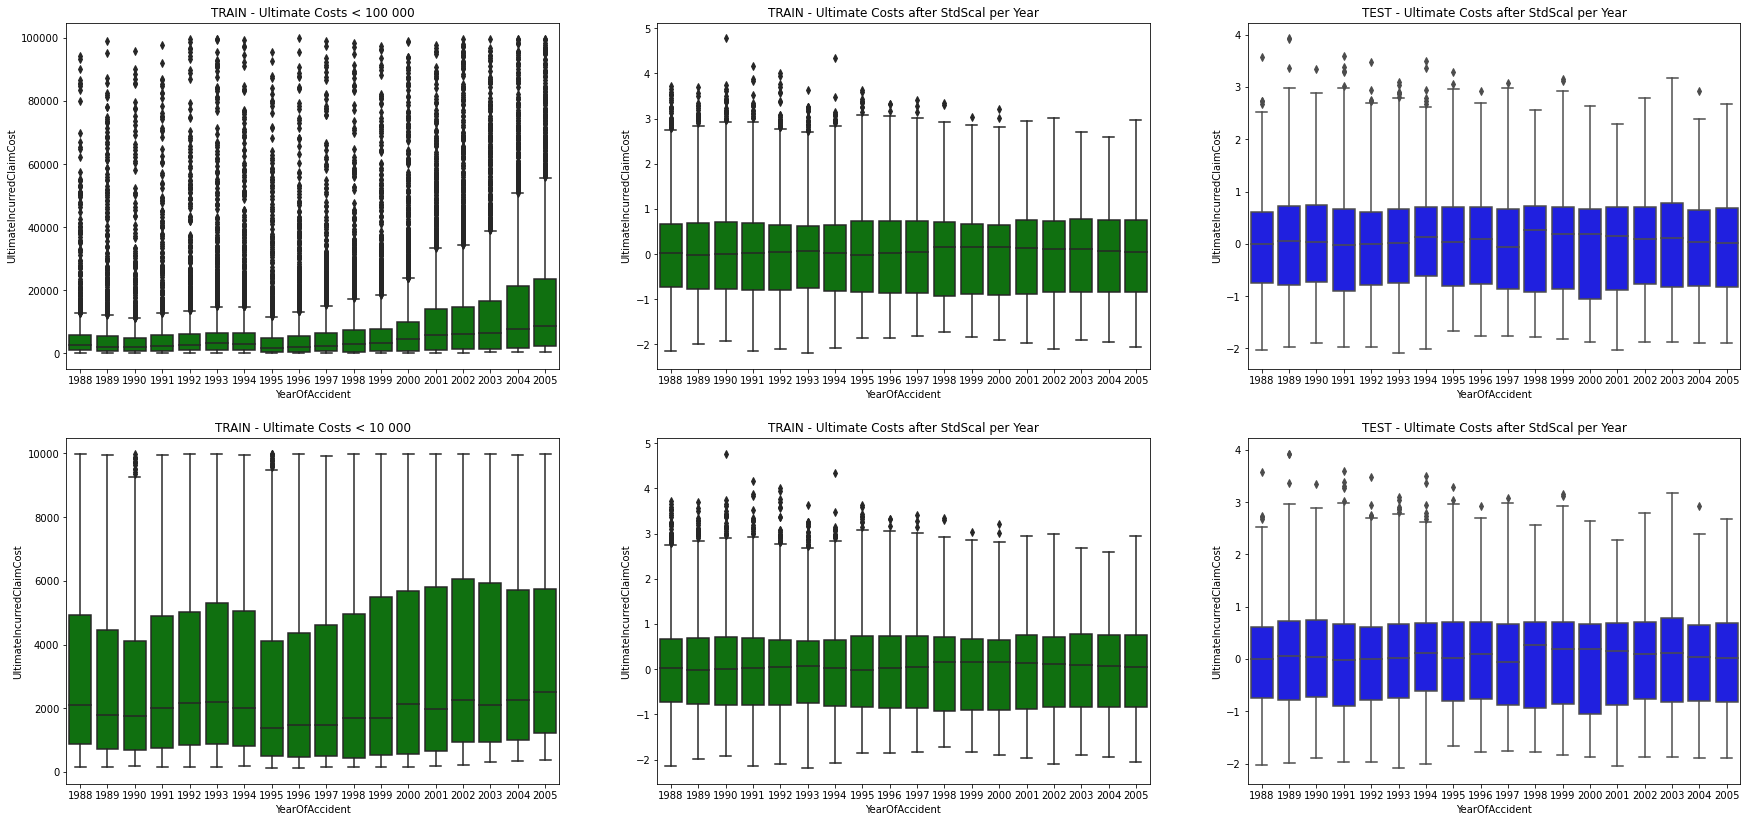

In [344]:
logstd = Log_StdScaler_ByGroup(feature = "UltimateIncurredClaimCost")
logstd.fit(X_tr)
df_temp1 = logstd.transform(X_tr)
df_temp2 = logstd.transform(X_te)

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(30, 14))

ax = plt.subplot(2, 3, 1)
sns.boxplot(y="UltimateIncurredClaimCost", x="YearOfAccident", data=train_set.loc[train_set["UltimateIncurredClaimCost"]<100000, ["YearOfAccident", "UltimateIncurredClaimCost"]], color="green", ax=ax)
#sns.boxplot(x="InitialIncurredCalimsCost", y="YearOfAccident", data=train_set[["YearOfAccident", "InitialIncurredCalimsCost"]], ax=ax, orient="h")
ax.set_title("TRAIN - Ultimate Costs < 100 000");

ax = plt.subplot(2, 3, 2)
sns.boxplot(y="UltimateIncurredClaimCost", x="YearOfAccident", data=df_temp1[["YearOfAccident", "UltimateIncurredClaimCost"]], color="green", ax=ax)
ax.set_title("TRAIN - Ultimate Costs after StdScal per Year");

ax = plt.subplot(2, 3, 3)
sns.boxplot(y="UltimateIncurredClaimCost", x="YearOfAccident", data=df_temp2[["YearOfAccident", "UltimateIncurredClaimCost"]], color="blue", ax=ax)
ax.set_title("TEST - Ultimate Costs after StdScal per Year");

ax = plt.subplot(2, 3, 4)
sns.boxplot(y="UltimateIncurredClaimCost", x="YearOfAccident", data=train_set.loc[train_set["UltimateIncurredClaimCost"]<10000, ["YearOfAccident", "UltimateIncurredClaimCost"]], color="green", ax=ax)
ax.set_title("TRAIN - Ultimate Costs < 10 000");

ax = plt.subplot(2, 3, 5)
sns.boxplot(y="UltimateIncurredClaimCost", x="YearOfAccident", data=df_temp1[["YearOfAccident", "UltimateIncurredClaimCost"]], color="green", ax=ax)
ax.set_title("TRAIN - Ultimate Costs after StdScal per Year");

ax = plt.subplot(2, 3, 6)
sns.boxplot(y="UltimateIncurredClaimCost", x="YearOfAccident", data=df_temp2[["YearOfAccident", "UltimateIncurredClaimCost"]], color="blue", ax=ax)
ax.set_title("TEST - Ultimate Costs after StdScal per Year");

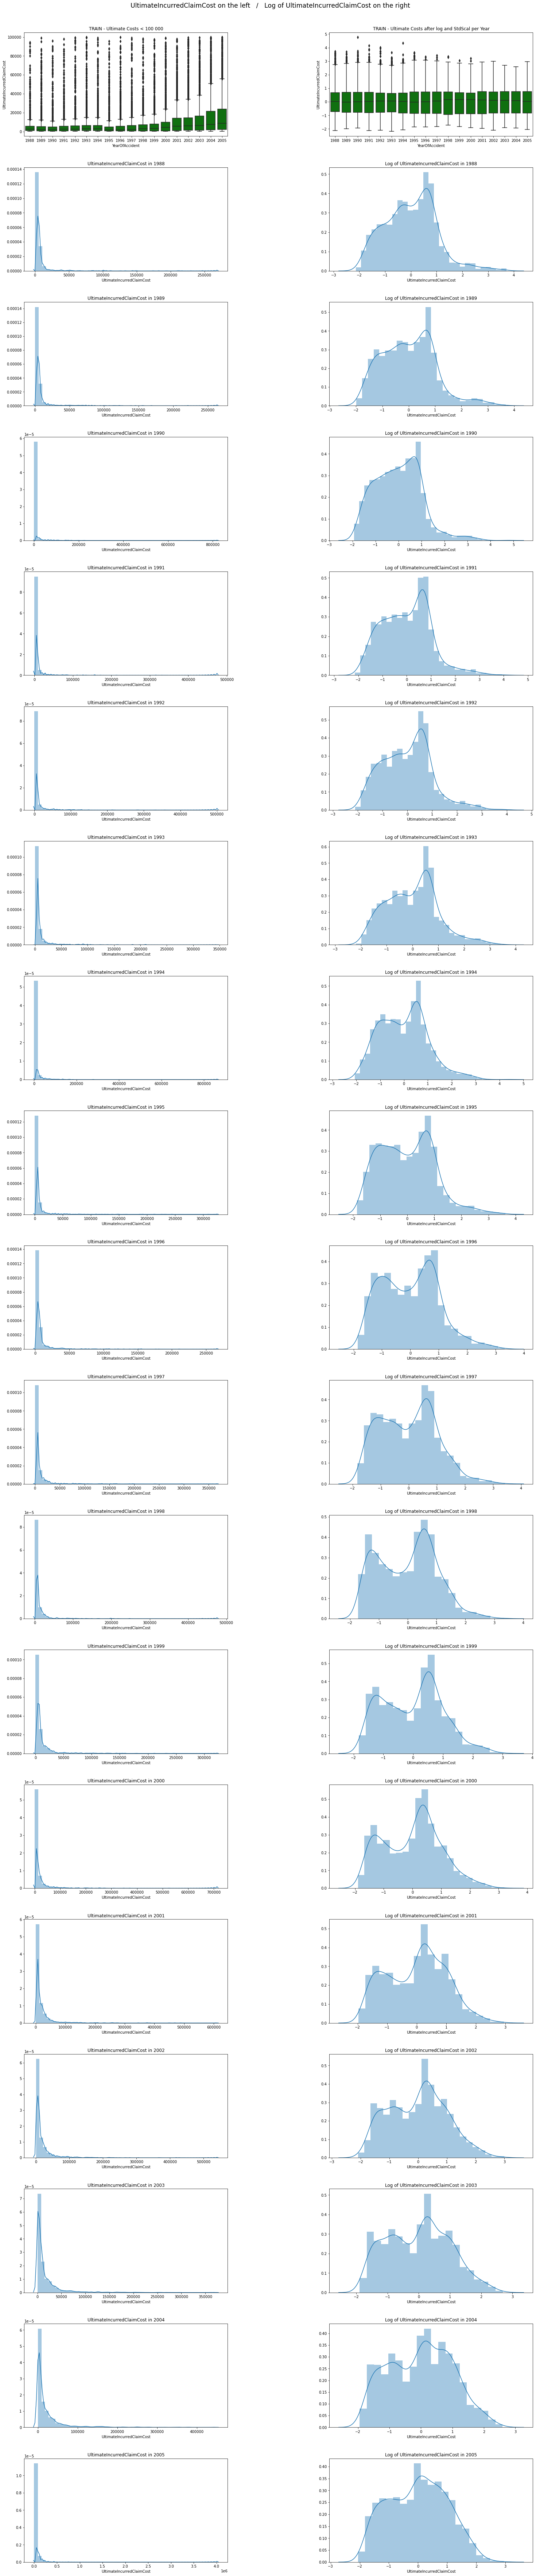

In [345]:
years = sorted(list(X_tr["YearOfAccident"].unique()))
fig, ax = plt.subplots(nrows = len(years) + 1, ncols = 2, figsize=(25, 6*(len(years)+1)))

logstd = Log_StdScaler_ByGroup()
logstd.fit(X_tr)
df_temp = logstd.transform(X_tr)

ax = plt.subplot(len(years)+1, 2, 1)
sns.boxplot(y="UltimateIncurredClaimCost", x="YearOfAccident", data=train_set.loc[train_set["UltimateIncurredClaimCost"]<100000, ["YearOfAccident", "UltimateIncurredClaimCost"]], color="green", ax=ax)
ax.set_title("TRAIN - Ultimate Costs < 100 000");

ax = plt.subplot(len(years)+1, 2, 2)
sns.boxplot(y="UltimateIncurredClaimCost", x="YearOfAccident", data=df_temp[["YearOfAccident", "UltimateIncurredClaimCost"]], color="green", ax=ax)
ax.set_title("TRAIN - Ultimate Costs after log and StdScal per Year");

for i, year in enumerate(years):
    
    plt.subplots_adjust(hspace = 0.3, wspace = 0.5)
    
    ax = plt.subplot(len(years)+1, 2, 2 * i + 3)
    sns.distplot(train_set.loc[train_set["YearOfAccident"] == year, "UltimateIncurredClaimCost"], ax = ax)
    ax.set_title(f"UltimateIncurredClaimCost in {year}");

    ax = plt.subplot(len(years)+1, 2, 2 * i + 4)
    sns.distplot(df_temp.loc[df_temp["YearOfAccident"] == year, "UltimateIncurredClaimCost"], ax = ax)
    ax.set_title(f"Log of UltimateIncurredClaimCost in {year}");

fig.subplots_adjust(top=0.97)
fig.suptitle("UltimateIncurredClaimCost on the left   /   Log of UltimateIncurredClaimCost on the right", fontsize="xx-large");

# del df_temp

## Initial Claim cost : before and after log transformation and per year of accident
After standard scaler transformation, Initial Claim Cost become independant of year of accident.

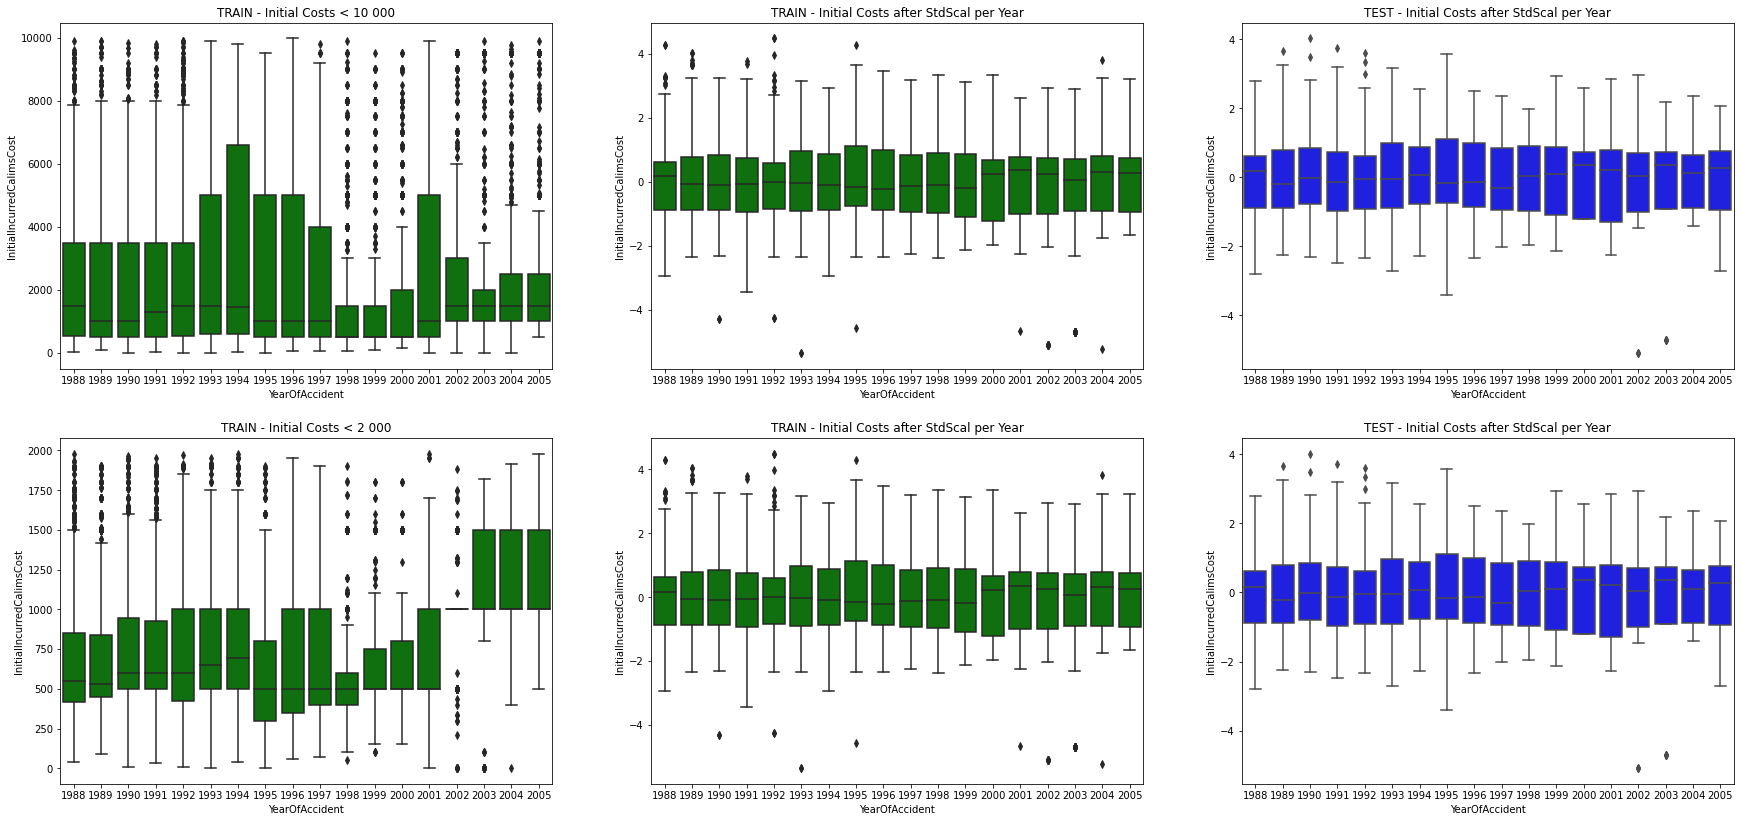

In [347]:
logstd = Log_StdScaler_ByGroup(feature = "InitialIncurredCalimsCost")
logstd.fit(X_tr)
df_temp1 = logstd.transform(X_tr)
df_temp2 = logstd.transform(X_te)

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(30, 14))

ax = plt.subplot(2, 3, 1)
sns.boxplot(y="InitialIncurredCalimsCost", x="YearOfAccident", data=train_set.loc[train_set["InitialIncurredCalimsCost"]<10000, ["YearOfAccident", "InitialIncurredCalimsCost"]], color="green", ax=ax)
#sns.boxplot(x="InitialIncurredCalimsCost", y="YearOfAccident", data=train_set[["YearOfAccident", "InitialIncurredCalimsCost"]], ax=ax, orient="h")
ax.set_title("TRAIN - Initial Costs < 10 000");

ax = plt.subplot(2, 3, 2)
sns.boxplot(y="InitialIncurredCalimsCost", x="YearOfAccident", data=df_temp1[["YearOfAccident", "InitialIncurredCalimsCost"]], color="green", ax=ax)
ax.set_title("TRAIN - Initial Costs after StdScal per Year");

ax = plt.subplot(2, 3, 3)
sns.boxplot(y="InitialIncurredCalimsCost", x="YearOfAccident", data=df_temp2[["YearOfAccident", "InitialIncurredCalimsCost"]], color="blue", ax=ax)
ax.set_title("TEST - Initial Costs after StdScal per Year");

ax = plt.subplot(2, 3, 4)
sns.boxplot(y="InitialIncurredCalimsCost", x="YearOfAccident", data=train_set.loc[train_set["InitialIncurredCalimsCost"]<2000, ["YearOfAccident", "InitialIncurredCalimsCost"]], color="green", ax=ax)
ax.set_title("TRAIN - Initial Costs < 2 000");

ax = plt.subplot(2, 3, 5)
sns.boxplot(y="InitialIncurredCalimsCost", x="YearOfAccident", data=df_temp1[["YearOfAccident", "InitialIncurredCalimsCost"]], color="green", ax=ax)
ax.set_title("TRAIN - Initial Costs after StdScal per Year");

ax = plt.subplot(2, 3, 6)
sns.boxplot(y="InitialIncurredCalimsCost", x="YearOfAccident", data=df_temp2[["YearOfAccident", "InitialIncurredCalimsCost"]], color="blue", ax=ax)
ax.set_title("TEST - Initial Costs after StdScal per Year");

## Weekly Wages : before and after standard scaler per year of accident
After standard scaler transformation, weekly wages become independant of year of accident.

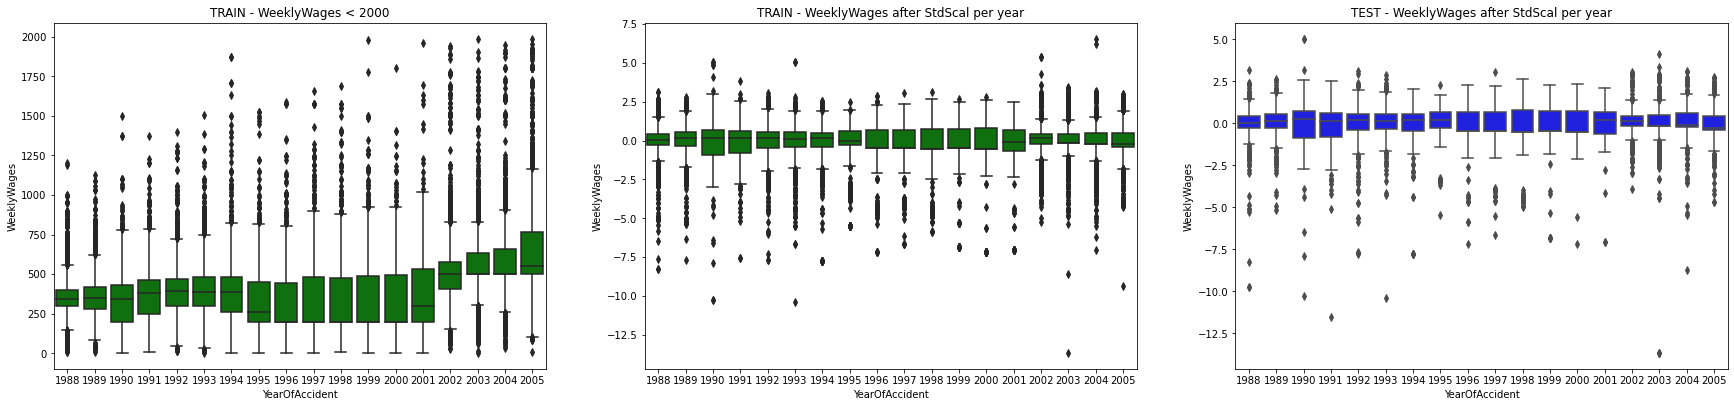

In [348]:
# With Log transformation

logstd = Log_StdScaler_ByGroup(feature = "WeeklyWages")
logstd.fit(X_tr)
df_temp1 = logstd.transform(X_tr)
df_temp2 = logstd.transform(X_te)


fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 14))

ax = plt.subplot(2, 3, 1)
sns.boxplot(y="WeeklyWages", x="YearOfAccident", data=train_set.loc[train_set["WeeklyWages"]<2000, ["YearOfAccident", "WeeklyWages"]], ax=ax, color="green")
ax.set_title("TRAIN - WeeklyWages < 2000");

ax = plt.subplot(2, 3, 2)
sns.boxplot(y="WeeklyWages", x="YearOfAccident", data=df_temp1[["YearOfAccident", "WeeklyWages"]], ax=ax, color="green")
ax.set_title("TRAIN - WeeklyWages after StdScal per year");

ax = plt.subplot(2, 3, 3)
sns.boxplot(y="WeeklyWages", x="YearOfAccident", data=df_temp2[["YearOfAccident", "WeeklyWages"]], ax=ax, color="blue")
ax.set_title("TEST - WeeklyWages after StdScal per year");

On the left size, number of folds where RMSE is increasing after values permutation (the feature is important in those folds). If RMSE is decresing after values permutation, the feature is useless on validation data.

On the right size, mean RMSE increase after value permutation, on all folds.

# 5 - Neural networks
Instead of label encoders for categorical features, i will use one hot encoder. Standardize continous features is now very important...

## A tool to detect columns per feature in the matrix after one hot encoding and the others transformations
This part is not very clean, I need a tool to understand feature importance in the NN ; but because I used a rich pipeline of transformation with one hot encoders (which create several columns for one feaure), I need this DIY. 

## Neural Network - Keras

In [381]:
from tensorflow import keras
from tensorflow.random import set_seed
from keras.constraints import maxnorm

In [382]:
def build_model(input_shape, dense_layers = [128, 128, 256], n_dropout_layer = 1, dropout_rate = .5
               , rate_dropout_input_layer = None
               , activation = "relu", seed = __seed):
    
    random.seed(seed) ; np.random.seed(seed) ; set_seed(seed)

    net = keras.models.Sequential()
    
    # Input Layer
    if rate_dropout_input_layer is None:
        net.add(keras.layers.Input(shape = input_shape))
    else:
        net.add(keras.layers.Dropout(rate = rate_dropout_input_layer, input_shape=(input_shape,), seed=seed))
    
    # Dense Layers
    n_dense_layer = len(dense_layers)
    for i, nn in enumerate(dense_layers):
        
        # Put a dropout layer after the lasts dense layers
        if n_dense_layer - i - 1 < n_dropout_layer:
            net.add(keras.layers.Dense(nn, activation = activation
                , kernel_initializer = keras.initializers.HeNormal(seed)
                , kernel_constraint = maxnorm(3)))
            net.add(keras.layers.Dropout(rate = dropout_rate, seed=seed))
        else:
            net.add(keras.layers.Dense(nn, activation = activation
                , kernel_initializer = keras.initializers.HeNormal(seed)))
            
    # Output layer
    net.add(keras.layers.Dense(1, activation="linear"))
    
    return net


nn_params = { "dense_layers":[128, 128, 128, 256, 256], "n_dropout_layer":4, "dropout_rate":.5
        , "rate_dropout_input_layer":None}
nn_params["input_shape"] = train_set.shape[1]
net = build_model(**nn_params)
print(net.summary())

del net

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 128)               3072      
_________________________________________________________________
dense_70 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_52 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_53 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_54 (Dropout)         (None, 256)             

In [397]:
%%time
def nn_cv(X_train, pipe, y_param, nn_params, learning_rate, batch_size
        , epochs=20, X_test = None, verbose = False, check_feature_importance = False
        , plot_history=False, early_stopping = False):

    scores = [] ; feat_imp = {} ; best_iteration_ = 0
    
    y_test, y_valid = None, pd.Series(np.zeros(len(X_train)), index=X_train.index)
    if not X_test is None: 
        X_test = X_test[list(X_train.columns)]
        y_test = pd.Series(np.zeros(len(X_test)), index=X_test.index)
        df_y_test = X_test[[y_param["groupby"]]].copy()
    
    if plot_history:
        fig, ax = plt.subplots(ncols = folds.n_splits, figsize=(30, 4.5 ))
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    
    # Main loop on each fold
        
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, X_train[y_param["groupby"]])):
                        
        # Samples selection on each fold
        X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
        y_trn, y_val, df_y_trn, df_y_val, y_logstd = create_y_true(X_trn, X_val, y_param)

        # Fit encoders and transform data
        _ = pipe.fit(X_trn)
        X_trn = pipe.transform(X_trn) ; X_val = pipe.transform(X_val)
    
        
        nn_params["input_shape"] = X_trn.shape[1]
        net = build_model(**nn_params)

            
        checkpoint = keras.callbacks.ModelCheckpoint("nn.h5", monitor = "val_loss"
                    , save_best_only = True, mode = "min", verbose = 0)
        lr_early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True
                    , monitor="val_loss", mode="min", verbose=0)
        lr_callback = keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 10, min_lr=learning_rate*.5**5)
        if early_stopping:
            callbacks = [checkpoint, lr_early_stopping, lr_callback]
        else:
            callbacks = [checkpoint, lr_callback]
        
        net.compile(loss = "mean_squared_error", optimizer = keras.optimizers.Adam(learning_rate = learning_rate))
        fitted = net.fit(x = X_trn, y = y_trn, batch_size = batch_size, 
            epochs = epochs, verbose = 0, callbacks = callbacks, validation_data = (X_val, y_val))

        # Prediction on validation samples
        net = keras.models.load_model("nn.h5")
        y_pred = net.predict(X_val)[:,0] ; y_valid.iloc[val_idx] = y_pred

        # Some plots
        if plot_history:
            
            temp = pd.DataFrame(fitted.history)[["loss", "val_loss"]].rename({"loss":"train_loss"}, axis=1) 
            temp.plot(ax=ax[fold_])
            ax[fold_].set_title(f"NN fit History - fold n°{fold_+1}")
            ax[fold_].set_xlabel('Epoch')
            ax[fold_].set_ylabel('Loss')
        

        # Prediction on Test samples
        if not X_test is None: 
            X_te = pipe.transform(X_test)
            y_te = net.predict(X_te)[:,0]
            y_te, _ = transform_y_pred(y_te, df_y_test, y_logstd)
            y_test += y_te / folds.n_splits
            
        # Inverse transform and score of validation prediction
        y_values, rmse_ = transform_y_pred(y_pred, df_y_val, y_logstd)
        y_valid.iloc[val_idx] = y_values ; scores.append(rmse_)
        if verbose: print("RMSE on fold {} : {:,.0f}".format(fold_, scores[fold_]))
            

    # End loop
            
    # Mean score
    if verbose: print("MEAN RMSE : {:,.0f}\n".format(np.array(scores).mean()))
    

    # End
    return {"rmse":np.array(scores).mean(), "y_test":y_test, "y_valid":y_valid, "y_pred_val":y_pred
           }



CPU times: user 0 ns, sys: 45 µs, total: 45 µs
Wall time: 50.1 µs


In [398]:

# Parameter for target transformation : log and stdscal
y_param = {"groupby" : "YearOfAccident", "feature" : 'UltimateIncurredClaimCost'
            , "stdscal" : True, "log" : np.log1p, "trunc_UltimateIncurredClaimCost" : True
            , "verbose" : False}

# NN parameters
nn_params = { "dense_layers":[128, 128, 128, 256], "n_dropout_layer":4, "dropout_rate":.05
        , "rate_dropout_input_layer":None}

num_topics =12
    
l_ohe_drop_first = ["MaritalStatus", "Gender", "PartTimeFullTime", "DependentsOther"
        , "word_right_in_description", "word_left_in_description", "word_strain_in_description"
        , 'DependentChildren', "WeekdayOfAccident", "WeekdayOfReported", "YearReportDelay"]
l_ohe_handle = ['max_topic_1', 'max_topic_2', 'YearOfAccident', 'MonthOfAccident']
l_stdscal = ['Age', 'HoursWorkedPerWeek', 'HourOfAccident'] + [f"topic_{j}" for j in range(num_topics)]
l_pass = ["InitialIncurredCalimsCost", "WeeklyWages" , "DaysReportDelay"]



pipe = make_pipeline(
search_dominant_topic(num_topics)
, Log_StdScaler_ByGroup(feature = "DaysReportDelay")
, Log_StdScaler_ByGroup(feature = "InitialIncurredCalimsCost")
, Log_StdScaler_ByGroup(feature = "WeeklyWages")
, make_column_transformer(
    (OneHotEncoder(sparse=False, dtype='uint8', drop="first"), l_ohe_drop_first)
    , (OneHotEncoder(sparse=False, dtype='uint8', handle_unknown="ignore"), l_ohe_handle)
    , (StandardScaler(), l_stdscal)
    , ("passthrough", l_pass)
, remainder="drop"))

RMSE on fold 0 : 23,560
RMSE on fold 1 : 25,723
RMSE on fold 2 : 25,091
RMSE on fold 3 : 23,573
RMSE on fold 4 : 21,728
MEAN RMSE : 23,935

Mean RMSE : 23,935 for num_topics 12


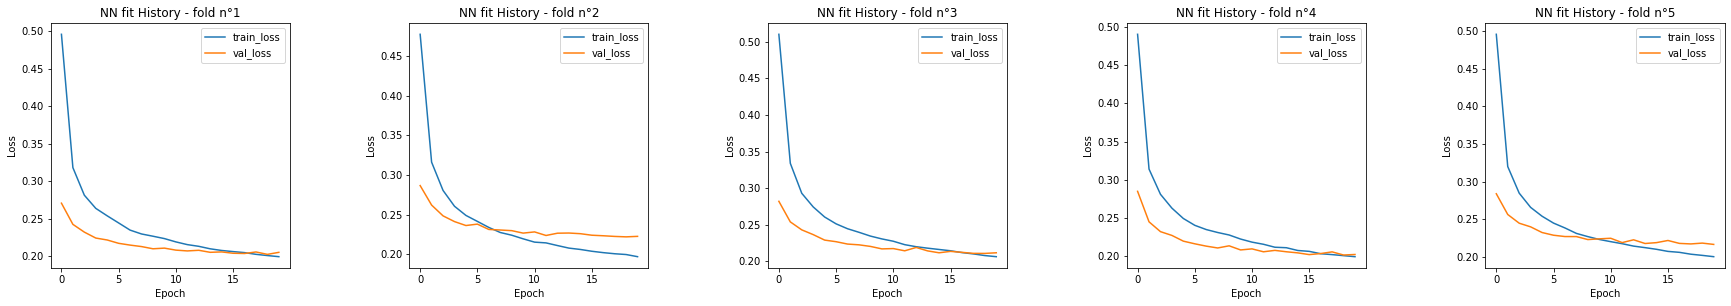

In [402]:
model_nn_AB = nn_cv(train_set[train_set['UltimateIncurredClaimCost']<800000], pipe, y_param=y_param
    , nn_params=nn_params, epochs=20, batch_size = 64, learning_rate = .0001
    , X_test = test_set
    , plot_history=True, check_feature_importance =False, early_stopping=True, verbose = True)

print(f"Mean RMSE : {model_nn_AB['rmse']:,.0f} for num_topics {num_topics}")

In [403]:
y_test = test_set.loc[:,"UltimateIncurredClaimCost"]
y_test

ClaimNumber
WC8285054     4748.203388
WC6982224     6326.285819
WC5481426     2293.949087
WC9775968    17786.487170
WC2634037     4014.002925
                 ...     
WC8632592     1190.981332
WC9186112     1699.658917
WC5797593      262.540740
WC6405443    35919.615880
WC2843680     1361.499466
Name: UltimateIncurredClaimCost, Length: 10800, dtype: float64

## Train lại model trên cả train + valid

In [404]:
import time


In [405]:

def train_traditional_nn(X_train, X_val, pipe, y_param, nn_params, epochs, learning_rate, batch_size
        , verbose = False
        , plot_history=False, early_stopping = False):
    
    y_valid = pd.Series(np.zeros(len(X_val)), index=X_val.index)

    if plot_history:
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 4.2 ))
        ax.set_xticks([0,5,10,15])
        
    val_idx = np.array(range(0,10800))

    y_trn, y_val, df_y_trn, df_y_val, y_logstd = create_y_true(X_train, X_val, y_param)

    _ = pipe.fit(X_train)
    X_trn = pipe.transform(X_train)
    X_val = pipe.transform(X_val)


    nn_params["input_shape"] = X_trn.shape[1]
    net = build_model(**nn_params)


    checkpoint = keras.callbacks.ModelCheckpoint("nn1.h5", monitor = "val_loss"
                , save_best_only = True, mode = "min", verbose = 0)
    lr_early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True
                , monitor="val_loss", mode="min", verbose=0)
    lr_callback = keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 10, min_lr=learning_rate*.5**5)
    if early_stopping:
        callbacks = [checkpoint, lr_early_stopping, lr_callback]
    else:
        callbacks = [checkpoint, lr_callback]

    net.compile(loss = "mean_squared_error", optimizer = keras.optimizers.Adam(learning_rate = learning_rate))
    fitted = net.fit(x = X_trn, y = y_trn, batch_size = batch_size, 
        epochs = epochs, verbose = 0, callbacks = callbacks, validation_data = (X_val, y_val))

    # Prediction on validation samples
    net = keras.models.load_model("nn1.h5")
    start = time.time()
    y_pred = net.predict(X_val)[:,0]
    y_valid.iloc[val_idx] = y_pred


    if plot_history:

        temp = pd.DataFrame(fitted.history)[["loss", "val_loss"]].rename({"loss":"train_loss"}, axis=1) 
        temp.plot(ax=ax)
        ax.set_title(f"NN fit History ")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')





    y_values, rmse_ = transform_y_pred(y_pred, df_y_val, y_logstd)
    y_valid.iloc[val_idx] = y_values 
    end = time.time()
    print('Inference time: ', end - start)
    if verbose: print("RMSE: {:,.0f}".format(rmse_))


    # End
    return {"rmse": rmse_, "y_valid_pred":y_valid, "y_pred":y_pred
           }
    

Inference time:  0.37089967727661133
RMSE: 24,462
CPU times: user 3min 20s, sys: 18 s, total: 3min 38s
Wall time: 2min 32s


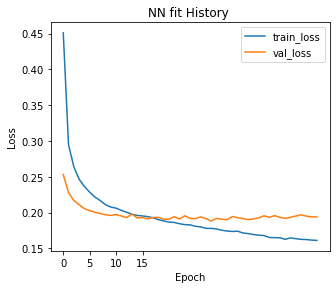

In [406]:
%%time
res = train_traditional_nn(train_set[train_set['UltimateIncurredClaimCost']<800000], test_set, pipe, y_param, nn_params, epochs=100, batch_size = 64, learning_rate = .0001
        , plot_history=True, early_stopping=True, verbose = True)


In [407]:
y_test_pred_2 = res['y_valid_pred']
y_test_pred_2

ClaimNumber
WC8285054     3663.386963
WC6982224     7334.105469
WC5481426     2208.241211
WC9775968    16751.166016
WC2634037     4663.959473
                 ...     
WC8632592     1195.452881
WC9186112     1564.065186
WC5797593      383.611450
WC6405443     7115.238281
WC2843680      570.308411
Length: 10800, dtype: float64

In [408]:
y_test = test_set['UltimateIncurredClaimCost']
y_test

ClaimNumber
WC8285054     4748.203388
WC6982224     6326.285819
WC5481426     2293.949087
WC9775968    17786.487170
WC2634037     4014.002925
                 ...     
WC8632592     1190.981332
WC9186112     1699.658917
WC5797593      262.540740
WC6405443    35919.615880
WC2843680     1361.499466
Name: UltimateIncurredClaimCost, Length: 10800, dtype: float64

In [409]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_tweedie_deviance,
    mean_squared_error,
)


In [410]:

rmse_nn = rmse(y_test_pred_2, y_test)
print(rmse_nn)

24461.559876143598


In [411]:
mean_absolute_error(y_test_pred_2, y_test)

5630.021310168142

In [412]:
for i in sample.index:
    print('index {}: real: {}, predict: {}'.format(i, sample.loc[i]['UltimateIncurredClaimCost'], y_test_pred_2[i]))

index WC7792914: real: 144508.9294, predict: 222777.921875
index WC8104294: real: 51362.33999, predict: 145630.0625
index WC5915110: real: 21109.38128, predict: 27920.189453125
index WC9879169: real: 558408.9616, predict: 99715.609375
index WC2633986: real: 53122.90481, predict: 47125.4296875
index WC2986786: real: 1701.953836, predict: 2117.303955078125
index WC1766625: real: 1538.284078, predict: 2897.29736328125
index WC8127373: real: 10854.46364, predict: 15198.2958984375
index WC5287454: real: 11322.77218, predict: 9970.34765625
index WC9548030: real: 17080.50011, predict: 22468.943359375


# 6 - BNN

In [413]:
# visualisation 
import matplotlib.pyplot as plt   # Plots
import plotly.express as px # PCA plots 
import seaborn as sns # Plots
import matplotlib as mpl
from cycler import cycler   # can help with assigning colors
from tabulate import tabulate # Creates tables
from sklearn.ensemble import ExtraTreesClassifier # Decision trees - used for feature importance
import matplotlib.lines as mlines # To be used for legends triangles/stars/other markers
# ML
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras import Sequential, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from keras import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from keras import regularizers
import tensorflow as tf
import tensorflow_probability as tfp

In [414]:
def build_bnn_model(x_train):
    # KL divergence function - to be used as input for flipout layers
    kl_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] *1.0)
        
    bnn_reg = Sequential()
    bnn_reg.add(Input(shape = 96))
    bnn_reg.add(tfp.layers.DenseVariational( units =155,
                             kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                             kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
                             kernel_divergence_fn = kl_divergence_fn,
                             activation = "relu"
                            )
           )

    bnn_reg.add(tfp.layers.DenseVariational( units =155,
                             kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                             kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
                             kernel_divergence_fn = kl_divergence_fn,
                             activation = "relu"
                            )
           )

    bnn_reg.add(tfp.layers.DenseVariational( units =155,
                             kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                             kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
                             kernel_divergence_fn = kl_divergence_fn,
                             activation = "relu"
                            )
           )

    bnn_reg.add(tfp.layers.DenseVariational( units =310,
                             kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                             kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
                             kernel_divergence_fn = kl_divergence_fn,
                             activation = "relu"
                            )
           )

    bnn_reg.add(tfp.layers.DenseVariational(units = 1, 
                                    kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                                    kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(), 
                                    kernel_divergence_fn = kl_divergence_fn,
                                        activation = "linear")
           )

    bnn_reg.compile( optimizer = "adam", loss = 'mse',
               metrics = [metrics.RootMeanSquaredError()]
               ) 

    history_bnn_reg = bnn_reg.fit(X_trn,y_trn, epochs = 20, validation_split = 0.1, 
                          batch_size = 64,
                          verbose = 0
                         )
    return bnn_reg

In [415]:
train_set['UltimateIncurredClaimCost'].describe()

count    4.320000e+04
mean     1.107319e+04
std      3.445196e+04
min      1.218868e+02
25%      9.231524e+02
50%      3.357361e+03
75%      8.213544e+03
max      4.027136e+06
Name: UltimateIncurredClaimCost, dtype: float64

In [416]:
%%time
def bnn(X_train, pipe, y_param, nn_params, epochs, learning_rate, batch_size
        , X_test = None, verbose = False, check_feature_importance = False
        , plot_history=False, early_stopping = False):

    scores = [] ; feat_imp = {} ; best_iteration_ = 0
    
    y_test, y_valid = None, pd.Series(np.zeros(len(X_train)), index=X_train.index)
    
    
    if not X_test is None: 
        X_test = X_test[list(X_train.columns)]
        y_test = pd.Series(np.zeros(len(X_test)), index=X_test.index)
        df_y_test = X_test[[y_param["groupby"]]].copy()
    
    if plot_history:
        fig, ax = plt.subplots(nrows = 1, ncols = folds.n_splits, figsize=(6* folds.n_splits, 4.5 ))
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    
    # Main loop on each fold

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, X_train[y_param["groupby"]])):
                        
        # Samples selection on each fold
        X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
        y_trn, y_val, df_y_trn, df_y_val, y_logstd = create_y_true(X_trn, X_val, y_param)

        y_val_pred = pd.Series(np.zeros(len(X_val)), index=X_val.index)
        
        # Fit encoders and transform data
        _ = pipe.fit(X_trn)
        X_trn = pipe.transform(X_trn) ; X_val = pipe.transform(X_val)

        
        np.random.seed(209)
        tf.random.set_seed(209)

        # KL divergence function - to be used as input for flipout layers
        kl_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] *1.0)

        bnn_reg = Sequential()
        bnn_reg.add(Input(shape = 96))
        bnn_reg.add(tfp.layers.DenseFlipout( units =128,
                                 kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                                 kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
                                 kernel_divergence_fn = kl_divergence_fn,
                                 activation = "relu"
                                )
               )

        bnn_reg.add(tfp.layers.DenseFlipout( units =128,
                                 kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                                 kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
                                 kernel_divergence_fn = kl_divergence_fn,
                                 activation = "relu"
                                )
               )

        bnn_reg.add(tfp.layers.DenseFlipout( units =128,
                                 kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                                 kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
                                 kernel_divergence_fn = kl_divergence_fn,
                                 activation = "relu"
                                )
               )

        bnn_reg.add(tfp.layers.DenseFlipout( units =256,
                                 kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                                 kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
                                 kernel_divergence_fn = kl_divergence_fn,
                                 activation = "relu"
                                )
               )

        bnn_reg.add(tfp.layers.DenseFlipout(units = 1, 
                                        kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                                        kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(), 
                                        kernel_divergence_fn = kl_divergence_fn,
                                            activation = "linear")
               )

        bnn_reg.compile( optimizer = "adam", loss = 'mse',
                   metrics = [metrics.RootMeanSquaredError()]
                   ) 

        history_bnn_reg = bnn_reg.fit(X_trn,y_trn, epochs = 20, validation_split = 0.1, 
                              batch_size = 64,
                              verbose = 0
                             )

        # Predict Y fit in train and measure scores
        pred_train_vi_reg= bnn_reg.predict(X_trn)
        scores_vi_reg = bnn_reg.evaluate(X_trn, y_trn, verbose=0)
        print('RMSE on training data: {} \n Error on training data: {}'.format(round(scores_vi_reg[1],3), round(scores_vi_reg[0],3)))   

        # Predict Y fit in test and measure scores
        pred_test_vi_reg= bnn_reg.predict(X_val)
        scores2_vi_reg = bnn_reg.evaluate(X_val, y_val, verbose=0)
        print('RMSE on test data: {} \n Error on test data: {}'.format(round(scores2_vi_reg[1],3),  round(scores2_vi_reg[0],3)))    
#         plot_loss_acc(history_bnn_reg, acc= False)
        
        y_pred = bnn_reg.predict(X_val)[:,0] ; y_valid.iloc[val_idx] = y_pred

        # Some plots
        if plot_history:
#             print(pd.DataFrame(history_bnn_reg.history))
            temp = pd.DataFrame(history_bnn_reg.history)[["loss", "val_loss"]].rename({"loss":"train_loss"}, axis=1) 
            temp.plot(ax=ax[fold_])
            ax[fold_].set_title(f"BNN fit History - fold n°{fold_+1}")
            ax[fold_].set_xlabel('Epoch')
            ax[fold_].set_ylabel('Loss')
            

#         X_te = pipe.transform(X_test)
#         y_te = bnn_reg.predict(X_te)[:,0]
#         y_te, _ = transform_y_pred(y_te, df_y_test, y_logstd)
#         y_test += y_te / folds.n_splits
    
        # Inverse transform and score of validation prediction
        y_values, rmse_ = transform_y_pred(y_pred, df_y_val, y_logstd)
        y_val_pred += y_values / folds.n_splits
        
        y_valid.iloc[val_idx] = y_values ; scores.append(rmse_)
        if verbose: print("RMSE on fold {} : {:,.0f}".format(fold_, scores[fold_]))
            

            
    # Mean score
#     if verbose: print("MEAN RMSE : {:,.0f}\n".format(np.array(scores).mean()))


    # End
    return {"rmse":np.array(scores).mean(), "y_val_pred":y_val_pred, "y_valid":y_val, "y_pred_val":y_pred,
            "model": bnn_reg
           }






CPU times: user 62 µs, sys: 0 ns, total: 62 µs
Wall time: 66 µs


## Train again in all train set (not split as NN CV)

In [417]:
%%time
def train_bnn(X_train, X_val, pipe, y_param, nn_params, epochs, learning_rate, batch_size
        , verbose = False
        , plot_history=False, early_stopping = False):


    
    y_valid = pd.Series(np.zeros(len(X_val)), index=X_val.index)
    
   
    
    if plot_history:
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(6, 6))
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    
   

    val_idx = np.array(range(0,10800))
#     trn_idx = np.array(range(10800,54000))
    # Samples selection on each fold
    y_trn, y_val, df_y_trn, df_y_val, y_logstd = create_y_true(X_train, X_val, y_param)

    # Fit encoders and transform data
    _ = pipe.fit(X_train)
    X_trn = pipe.transform(X_train)
    X_val = pipe.transform(X_val)

        
    np.random.seed(209)
    tf.random.set_seed(209)

    # KL divergence function - to be used as input for flipout layers
    kl_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] *1.0)

    bnn_reg = Sequential()
    bnn_reg.add(Input(shape = 96))
    bnn_reg.add(tfp.layers.DenseFlipout( units =128,
                             kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                             kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
                             kernel_divergence_fn = kl_divergence_fn,
                             activation = "relu"
                            )
           )

    bnn_reg.add(tfp.layers.DenseFlipout( units =128,
                             kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                             kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
                             kernel_divergence_fn = kl_divergence_fn,
                             activation = "relu"
                            )
           )

    bnn_reg.add(tfp.layers.DenseFlipout( units =128,
                             kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                             kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
                             kernel_divergence_fn = kl_divergence_fn,
                             activation = "relu"
                            )
           )

    bnn_reg.add(tfp.layers.DenseFlipout( units =256,
                             kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                             kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
                             kernel_divergence_fn = kl_divergence_fn,
                             activation = "relu"
                            )
           )
    bnn_reg.add(tfp.layers.DenseFlipout( units =256,
                             kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                             kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
                             kernel_divergence_fn = kl_divergence_fn,
                             activation = "relu"
                            )
           )
    
    bnn_reg.add(tfp.layers.DenseFlipout(units = 1, 
                                    kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
                                    kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(), 
                                    kernel_divergence_fn = kl_divergence_fn,
                                        activation = "linear")
           )

    bnn_reg.compile( optimizer = "adam", loss = 'mse',
               metrics = [metrics.RootMeanSquaredError()]
               ) 

    history_bnn_reg = bnn_reg.fit(X_trn,y_trn, epochs = epochs, validation_split = 0.1, 
                          batch_size = 64,
                          verbose = 0
                         )

        
   
#         Some plots
    if plot_history:
#         print(pd.DataFrame(history_bnn_reg.history))
        temp = pd.DataFrame(history_bnn_reg.history)[["loss", "val_loss"]].rename({"loss":"train_loss"}, axis=1) 
        temp.plot(ax=ax)
        ax.set_title(f"BNN fit History")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')


    # y_pred là sau log std, trước khi chuyển về đvi bth
    return {"rmse": rmse_, "y_val_pred":y_valid, 'X_trn':X_trn, 'y_trn': y_trn, 'X_val': X_val, 'y_val': y_val,
            "model": bnn_reg, 'df_y_val':df_y_val, 'y_logstd':y_logstd, 'val_idx':val_idx
           }





CPU times: user 98 µs, sys: 12 µs, total: 110 µs
Wall time: 134 µs


In [418]:

def predict(X_val, model, df_y_val, y_logstd):
    
    y_valid = pd.Series(np.zeros(len(X_val)), index=X_val.index)

    val_idx = np.array(range(0,len(X_val)))

    df_y_val = X_val[[y_param["groupby"], "UltimateIncurredClaimCost"]].copy()
    df_y_val.rename({"UltimateIncurredClaimCost":"y_true"}, inplace = True, axis = 1)
    
    X_val = pipe.transform(X_val)
    y_pred = model.predict(X_val)[:,0] 


    
    # Inverse transform and score of validation prediction
    y_values, rmse_ = transform_y_pred(y_pred, df_y_val, y_logstd)

    y_valid.iloc[val_idx] = y_values
    
    return y_valid


CPU times: user 7min 46s, sys: 21.2 s, total: 8min 7s
Wall time: 3min 21s


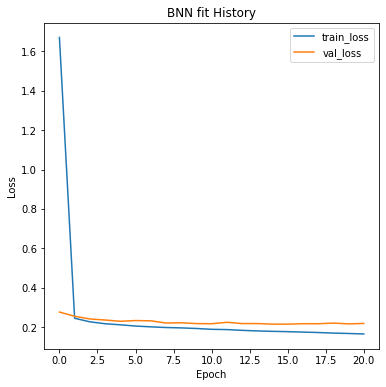

In [419]:
%%time
model_bnn = train_bnn(train_set[train_set['UltimateIncurredClaimCost']<800000], test_set, pipe, y_param, nn_params, epochs=21, batch_size = 64, learning_rate = .0001
        , plot_history=True, early_stopping=True, verbose = True)




In [420]:
model = model_bnn['model']
df_y_test = model_bnn['df_y_val']
y_logstd = model_bnn['y_logstd']
# test_idx = model_bnn['val_idx']
y_valid = model_bnn['y_val_pred']

start = time.time()
y_test_pred = predict(test_set, model, df_y_test, y_logstd)

time.time() - start
# y_test_pred = predict(X_val, model, df_y_test, y_logstd)

5.9241719245910645

In [421]:
test_set

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost,YearOfAccident,YearReported,MonthOfAccident,DayOfAccident,WeekdayOfAccident,HourOfAccident,WeekdayOfReported,DaysReportDelay,YearReportDelay
ClaimNumber,,,,,,,,,,,,,,,,,,,,,,,
WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388,2002,2002,4,9,Tuesday,7,Friday,87,0
WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819,1999,1999,1,7,Thursday,11,Wednesday,13,0
WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087,1996,1996,3,25,Monday,0,Sunday,20,0
WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170,2005,2005,6,22,Wednesday,13,Friday,30,0
WC2634037,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925,1990,1990,8,29,Wednesday,8,Thursday,29,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC8632592,2003-05-23T14:00:00Z,2003-06-27T00:00:00Z,34,M,M,0,0,491.81,F,40.0,5,STRUCK KNIFE LACERATED LEFT LEG,1500,1190.981332,2003,2003,5,23,Friday,14,Friday,35,0
WC9186112,2004-08-30T08:00:00Z,2004-11-07T00:00:00Z,46,M,S,0,0,800.00,F,38.0,5,STRUCK GRINDER LACERATION LEFT HAND THUMB,1500,1699.658917,2004,2004,8,30,Monday,8,Sunday,69,0
WC5797593,1996-08-08T08:00:00Z,1996-09-07T00:00:00Z,15,M,S,0,0,200.00,P,5.0,2,CUTTING TIMBER WITH SAW FOREIGN BODY RIGHT CORNEA,350,262.540740,1996,1996,8,8,Thursday,8,Saturday,30,0


In [422]:
y_test_pred = predict(test_set, model, df_y_test, y_logstd)

In [423]:
y_test_pred.values

array([2703.25278102, 5464.81490872, 2683.08692246, ...,  378.75686768,
       6305.6233962 ,  550.51001207])

In [424]:
rmse(y_test_pred, y_test)

25005.406019951348

In [425]:
mean_absolute_error(y_test_pred, y_test)

5884.206076445973

## Visualize

In [426]:

sample = test_set[test_set.index.isin(sample.index)].reindex(['WC7792914', 'WC8104294', 'WC5915110', 'WC9879169', 'WC2633986',
       'WC2986786', 'WC1766625', 'WC8127373', 'WC5287454', 'WC9548030'])

In [427]:
targets = sample['UltimateIncurredClaimCost']

In [429]:
### Visualize prediction of BNN
def compute_predictions(model, iterations=1000):
    predicted = []
    for _ in range(iterations):
        predicted.append(predict(sample, model, df_y_test, y_logstd).values)
#     print(predicted)
    return np.array(predicted)

def display_predictions(predictions, targets):
    prediction_mean = np.mean(predictions, axis=1)
    prediction_min = np.min(predictions, axis=1)
    prediction_max = np.max(predictions, axis=1)
    prediction_range = (np.max(predictions, axis=1) - np.min(predictions, axis=1))

    for idx in range(10):
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"min: {round(prediction_min[idx], 2)}, "
            f"max: {round(prediction_max[idx], 2)}, "
            f"range: {round(prediction_range[idx], 2)} - "
            f"Actual: {targets[idx]}"
        )



In [430]:
predictions = compute_predictions(model)
# display_predictions(predictions, targets)

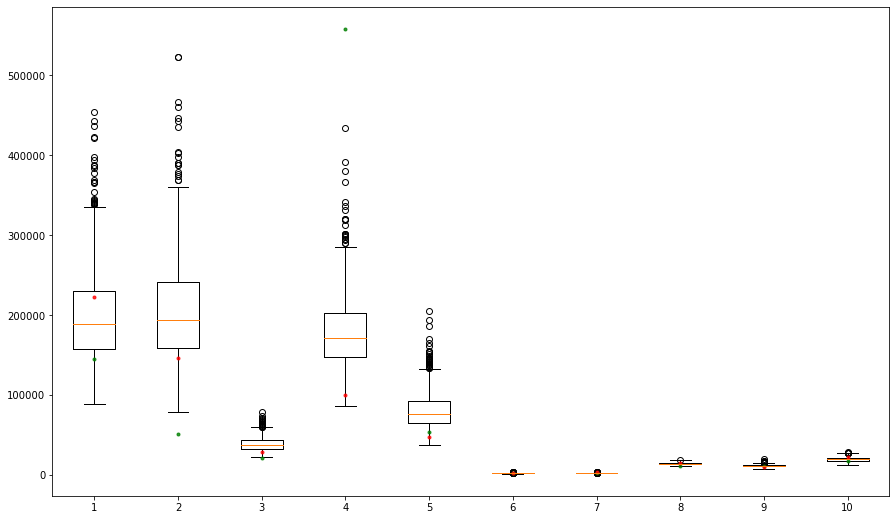

In [431]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,9))

plt.boxplot(predictions)
plt.plot(range(1,11), targets, 'g.', alpha=0.8)
plt.plot(range(1,11), y_test_pred_2[y_test_pred_2.index.isin(sample.index)].reindex(['WC7792914', 'WC8104294', 'WC5915110', 'WC9879169', 'WC2633986',
       'WC2986786', 'WC1766625', 'WC8127373', 'WC5287454', 'WC9548030']), 'r.', alpha=0.8)


In [432]:
 targets

ClaimNumber
WC7792914    144508.929400
WC8104294     51362.339990
WC5915110     21109.381280
WC9879169    558408.961600
WC2633986     53122.904810
WC2986786      1701.953836
WC1766625      1538.284078
WC8127373     10854.463640
WC5287454     11322.772180
WC9548030     17080.500110
Name: UltimateIncurredClaimCost, dtype: float64

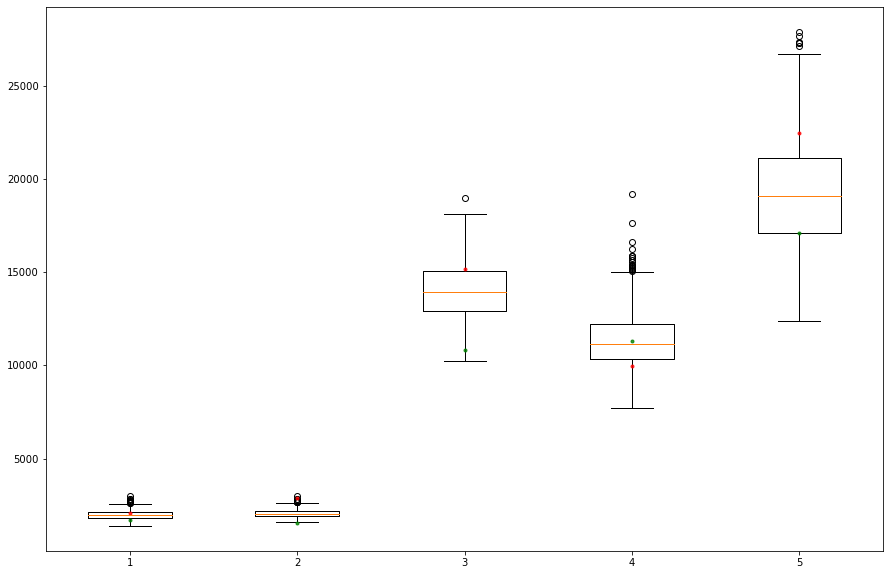

In [433]:

plt.figure(figsize=(15,10))
predicted_t = y_test_pred_2[y_test_pred_2.index.isin(sample.index)].reindex(['WC7792914', 'WC8104294', 'WC5915110', 'WC9879169', 'WC2633986',
       'WC2986786', 'WC1766625', 'WC8127373', 'WC5287454', 'WC9548030'])
plt.boxplot(predictions[:,5:11])
plt.plot(range(1,6), targets[-5:], 'g.', alpha=0.8)
plt.plot(range(1,6), predicted_t[-5:], 'r.', alpha=0.8)


In [434]:
targets

ClaimNumber
WC7792914    144508.929400
WC8104294     51362.339990
WC5915110     21109.381280
WC9879169    558408.961600
WC2633986     53122.904810
WC2986786      1701.953836
WC1766625      1538.284078
WC8127373     10854.463640
WC5287454     11322.772180
WC9548030     17080.500110
Name: UltimateIncurredClaimCost, dtype: float64

In [435]:
display_predictions(predictions, targets)

Predictions mean: 61426.63, min: 1953.52, max: 151282.27, range: 149328.75 - Actual: 144508.9294
Predictions mean: 74881.14, min: 2170.6, max: 235081.47, range: 232910.87 - Actual: 51362.33999
Predictions mean: 70380.73, min: 1829.94, max: 290433.28, range: 288603.33 - Actual: 21109.38128
Predictions mean: 72685.35, min: 1901.75, max: 211920.63, range: 210018.88 - Actual: 558408.9616
Predictions mean: 63968.49, min: 1996.94, max: 175019.73, range: 173022.79 - Actual: 53122.90481
Predictions mean: 70500.43, min: 1722.54, max: 203788.84, range: 202066.31 - Actual: 1701.953836
Predictions mean: 98997.56, min: 1767.97, max: 278015.9, range: 276247.93 - Actual: 1538.284078
Predictions mean: 95841.71, min: 1842.54, max: 254851.01, range: 253008.47 - Actual: 10854.46364
Predictions mean: 82179.2, min: 2041.69, max: 257859.01, range: 255817.32 - Actual: 11322.77218
Predictions mean: 78811.72, min: 1946.45, max: 289896.04, range: 287949.58 - Actual: 17080.50011


# 7 - GLM

In [436]:
x_train = model_bnn['X_trn']
y_train = pd.DataFrame(model_bnn['y_trn'])

x_val = model_bnn['X_val']
y_val = pd.DataFrame(model_bnn['y_val'])

In [437]:


def score_estimator(estimator, x_val, y_val):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(x_val)

    print(
        "RMSE: %.3f"
        % np.sqrt(mean_squared_error(
            y_val, y_pred
        ))
    )
    
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            y_val, y_pred
        )
    )

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "mean Tweedie deviance: %.3f"
        % mean_tweedie_deviance(
            y_val[mask],
            y_pred[mask]
        )
    )

    

In [438]:
%%time
from sklearn.linear_model import GammaRegressor, TweedieRegressor, PoissonRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

n_samples = x_train.shape[0]

Tweedie_glm = Pipeline(
    [
     ("regressor",  TweedieRegressor(alpha=1e-12, power=0))

    ]
)
Tweedie_glm.fit(
    x_train, y_train
)

print("Regressor evaluation:")
score_estimator(Tweedie_glm, x_val, y_val)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Regressor evaluation:
RMSE: 0.462
MAE: 0.314
mean Tweedie deviance: 0.213
CPU times: user 559 ms, sys: 11.2 ms, total: 570 ms
Wall time: 288 ms


In [439]:
%%time
start = time.time()
Tweedie_predictions = Tweedie_glm.predict(x_val)
Tweedie_predictions

time.time() - start

CPU times: user 5.15 ms, sys: 871 µs, total: 6.03 ms
Wall time: 2.43 ms


0.0024046897888183594

<!-- 5.12 ms -->

In [440]:
rmse(Tweedie_predictions, y_val)

0.4617194449040374

In [441]:
mean_absolute_error(Tweedie_predictions, y_val)

0.31397384026894887

In [442]:
y_values, rmse_ = transform_y_pred(Tweedie_predictions, df_y_test, y_logstd)
rmse_

24490.40438666276

In [443]:
rmse(y_values, y_test)

24490.40438666276

In [444]:
mean_absolute_error(y_values, y_test)

5857.543406406276

## Note: 
Performance (RMSE, MAE) changes a little bit when training models again. Sometimes GLM is better than BNN, and vice versa, and NN usually has the highest performance. 

However, we should know that BNN brings the UNCERTAINTY LEVEL to the model, which NN can not. 